# Developement of optimization algorithm

In optimization_developement.ipynb I build a relatively simplemodel which can take different parameters as input and thus can be easily changed.

The next aim is developing an algorithm to find a good model. The difference compared to classical fitting is that the no constant truth which is fit, thus standard implementations of the usual algorithms do not work. 

First all needed libraries and own functions are imported.

In [1]:
import numpy as np
import random as random
from numpy.random import seed
from numpy.random import rand
import scipy
#using simpleguitk for display, is not needed for computer game
import simpleguitk as simplegui
import time
#new ones
import pandas as pd
#ml methods
from xgboost import XGBRegressor
from xgboost import XGBClassifier
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import os
#skyjo game classes and functions 
from skyjo_functions4 import *
#own functions for machine learning
from ml_functions2 import *
#for plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#for confidence intervalls
from scipy.stats import beta
#for fitting of x y data 
from scipy.optimize import curve_fit
#for splitting
from sklearn.model_selection import train_test_split
#confusing matrix
from sklearn.metrics import confusion_matrix
#for saving and loading of stranger object
import pickle

Any fit needs to start with with at least one mdoel to play against. This very first is when all parameters are 0. 
Asd the next step I try a change only one parameter at a time the first step to a gradient based algorithm.
It has input the step sizes for all parameters and the number of relaizations the model is run. 

In [2]:
#means changes within the function do not have an effect outside of it , copy it to the top functions does not change anything 
def first_gradient_step(open_steps,discard_steps,value_steps,realizations):
    n_it=realizations
    results=np.zeros((40,19))
    for j in range(results.shape[1]):
        print(f"doing case {j}")
        level20_open_variable=np.zeros((6))
        level20_discard_variable=np.zeros((6))
        level20_value_variable=np.zeros((7))
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        if j<6:
            level21_open_variable[j]=open_steps[j]
        elif j<12:
            level21_discard_variable[j-6]=discard_steps[j-6]
        else:
            level21_value_variable[j-12]=value_steps[j-12]    
        print(level21_open_variable,level21_discard_variable,level21_value_variable)
        results[0:6,j]=level20_open_variable
        results[6:12,j]=level20_discard_variable
        results[12:19,j]=level20_value_variable    
        results[19:25,j]=level21_open_variable
        results[25:31,j]=level21_discard_variable
        results[31:38,j]=level21_value_variable         
        win20=0
        start_time=time.time()
        for i in range(n_it):
            names=['alpha','beta']
            nature=['computer','computer']
            levels=[20,21]
            winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
            if winner[0]==1:
                win20+=1
        results[38,j]=n_it
        results[39,j]=win20
        stop_time=time.time()
        print(f"{n_it} games need {np.round(stop_time-start_time,3)} seconds")
        print(f"level 20 won to {np.round(win20*100/n_it,1)} %")
    return results     

I run it several times, with the aims of finding which parameter size matters for winning, since it is clear that it will saturate at some point since the range of outcomes is limited. 

In [27]:
factors=[-0.00005,-0.0001,-0.0002,-0.0005,-0.001,-0.002,-0.005,-0.01,-0.02,-0.05,-0.1]
for i in range(len(factors)):
    print(f"doing factor {factors[i]}")
    open_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    discard_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    value_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    #does not recreated levls good 
    result=first_gradient_step(open_step,discard_step,value_step,400)
    #outcommented that it is not overwritten by chance
    #np.savetxt("gradient_level20_vm"+str(i)+".txt",result)

doing factor -5e-05
doing case 0
[-5.e-05  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.707 seconds
level 20 won to 45.0 %
doing case 1
[ 0.e+00 -5.e-05  0.e+00  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.628 seconds
level 20 won to 50.0 %
doing case 2
[ 0.e+00  0.e+00 -5.e-05  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.47 seconds
level 20 won to 49.0 %
doing case 3
[ 0.e+00  0.e+00  0.e+00 -5.e-05  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.62 seconds
level 20 won to 50.5 %
doing case 4
[ 0.e+00  0.e+00  0.e+00  0.e+00 -5.e-05  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.127 seconds
level 20 won to 48.2 %
doing case 5
[ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -5.e-05] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.84 seconds
level 20 won to 49.0 %
doing case 6
[0. 0. 0. 0. 0. 

400 games need 22.451 seconds
level 20 won to 52.2 %
doing case 13
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.     -0.0002  0.      0.      0.      0.      0.    ]
400 games need 21.956 seconds
level 20 won to 48.2 %
doing case 14
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.     -0.0002  0.      0.      0.      0.    ]
400 games need 21.796 seconds
level 20 won to 49.5 %
doing case 15
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.     -0.0002  0.      0.      0.    ]
400 games need 21.297 seconds
level 20 won to 61.2 %
doing case 16
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.     -0.0002  0.      0.    ]
400 games need 21.807 seconds
level 20 won to 50.5 %
doing case 17
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.      0.     -0.0002  0.    ]
400 games need 20.862 seconds
level 20 won to 57.5 %
doing case 18
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.      0.      0.     -0.0002]
400 games 

400 games need 24.202 seconds
level 20 won to 49.8 %
doing case 8
[0. 0. 0. 0. 0. 0.] [ 0.     0.    -0.002  0.     0.     0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 25.193 seconds
level 20 won to 41.5 %
doing case 9
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.    -0.002  0.     0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.484 seconds
level 20 won to 15.2 %
doing case 10
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.     0.    -0.002  0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.745 seconds
level 20 won to 41.2 %
doing case 11
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.     0.     0.    -0.002] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.914 seconds
level 20 won to 16.5 %
doing case 12
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [-0.002  0.     0.     0.     0.     0.     0.   ]
400 games need 21.812 seconds
level 20 won to 53.0 %
doing case 13
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.    -0.002  0.     0.     0.     0.     0.   ]
400 games need 20.24 seconds
level 20 won to 67.8 %
doing case 14
[0. 

400 games need 25.533 seconds
level 20 won to 41.0 %
doing case 5
[ 0.    0.    0.    0.    0.   -0.02] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 25.576 seconds
level 20 won to 38.5 %
doing case 6
[0. 0. 0. 0. 0. 0.] [-0.02  0.    0.    0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.114 seconds
level 20 won to 30.0 %
doing case 7
[0. 0. 0. 0. 0. 0.] [ 0.   -0.02  0.    0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 27.617 seconds
level 20 won to 32.2 %
doing case 8
[0. 0. 0. 0. 0. 0.] [ 0.    0.   -0.02  0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.844 seconds
level 20 won to 18.2 %
doing case 9
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.   -0.02  0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.598 seconds
level 20 won to 13.2 %
doing case 10
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.    0.   -0.02  0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 27.52 seconds
level 20 won to 19.2 %
doing case 11
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.    0.    0.   

Running that time, that needs to be considered, that a fit does not take too long. Also since there is not a fully defined truth it is less important to be very good against a model, since it is more important to be good overall since a very good performance against a model could be just a good solution agianst this but not in general. 

Now I am loading all positive factors file and combine them in a file for plotting to find where the gradient flattens for the different parameters.

In [34]:
gra1=np.loadtxt("gradient_level20_v1.txt")
gra2=np.loadtxt("gradient_level20_v2.txt")
gra3=np.loadtxt("gradient_level20_v3.txt")
gra4=np.loadtxt("gradient_level20_v4.txt")
gra5=np.loadtxt("gradient_level20_v5.txt")
gra6=np.loadtxt("gradient_level20_v6.txt")
gra7=np.loadtxt("gradient_level20_v7.txt")
gra8=np.loadtxt("gradient_level20_v8.txt")
gra9=np.loadtxt("gradient_level20_v9.txt")
gra10=np.loadtxt("gradient_level20_v10.txt")
gra11=np.loadtxt("gradient_level20_v11.txt")
gra12=np.loadtxt("gradient_level20_v12.txt")
gra13=np.loadtxt("gradient_level20_v13.txt")
gra14=np.loadtxt("gradient_level20_v14.txt")
compp=np.zeros((20,14))
compp[0,:]=np.array([1,0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001,0.00005])
compp[1:20,0]=gra1[39,:]/gra1[38,:]
compp[1:20,1]=gra2[39,:]/gra2[38,:]
compp[1:20,2]=gra3[39,:]/gra3[38,:]
compp[1:20,3]=gra4[39,:]/gra4[38,:]
compp[1:20,4]=gra5[39,:]/gra5[38,:]
compp[1:20,5]=gra6[39,:]/gra6[38,:]
compp[1:20,6]=gra7[39,:]/gra7[38,:]
compp[1:20,7]=gra8[39,:]/gra8[38,:]
compp[1:20,8]=gra9[39,:]/gra9[38,:]
compp[1:20,9]=gra10[39,:]/gra10[38,:]
compp[1:20,10]=gra11[39,:]/gra11[38,:]
compp[1:20,11]=gra12[39,:]/gra12[38,:]
compp[1:20,12]=gra13[39,:]/gra13[38,:]
compp[1:20,13]=gra14[39,:]/gra14[38,:]

Now I plot them, separately for three different actions which take parameters. Starting with the parameters for action of taking open pile card or not.

Text(0.5, 1.0, 'taking open pile card')

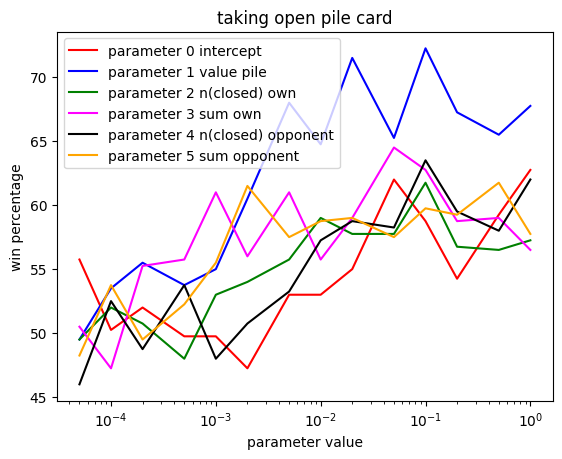

In [4]:
plt.plot(compp[0,:],100*compp[1,:],color='red',label='parameter 0 intercept') 
plt.plot(compp[0,:],100*compp[2,:],color='blue',label='parameter 1 value pile') 
plt.plot(compp[0,:],100*compp[3,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compp[0,:],100*compp[4,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compp[0,:],100*compp[5,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compp[0,:],100*compp[6,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("taking open pile card")

No action gets very large percentages here, but as expected the value of the open card matters most.

Text(0.5, 1.0, 'discarding closed pile card')

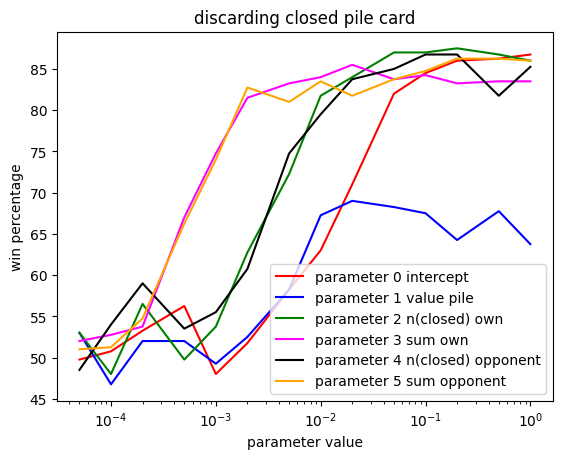

In [5]:
plt.plot(compp[0,:],100*compp[7,:],color='red',label='parameter 0 intercept') 
plt.plot(compp[0,:],100*compp[8,:],color='blue',label='parameter 1 value pile') 
plt.plot(compp[0,:],100*compp[9,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compp[0,:],100*compp[10,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compp[0,:],100*compp[11,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compp[0,:],100*compp[12,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("discarding closed pile card")

Here the parameter more, since that is more related to finishing games first or second. In a random strategy finishing second is better since otherwise the score can be doubled when it is higher than the oppoenents. 
Sum matters for smaller paremeters because its numbers are smaller than for the number of closed cards and the values of cards. 

Text(0.5, 1.0, 'playing closed or maximum value')

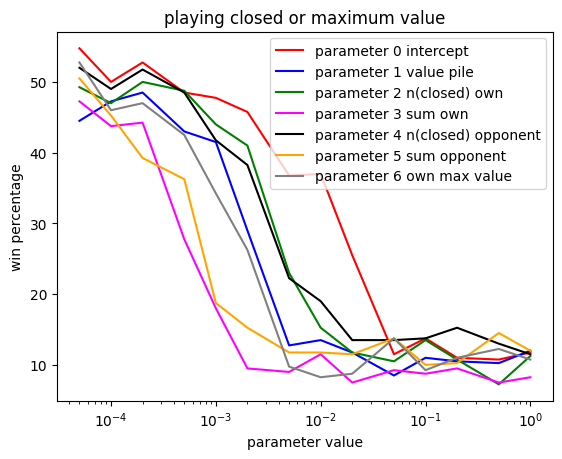

In [5]:
plt.plot(compp[0,:],100*compp[13,:],color='red',label='parameter 0 intercept') 
plt.plot(compp[0,:],100*compp[14,:],color='blue',label='parameter 1 value pile') 
plt.plot(compp[0,:],100*compp[15,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compp[0,:],100*compp[16,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compp[0,:],100*compp[17,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compp[0,:],100*compp[18,:],color='orange',label='parameter 5 sum opponent') 
plt.plot(compp[0,:],100*compp[19,:],color='gray',label='parameter 6 own max value') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("playing closed or maximum value")

Similar as before, after the sum also the value of the maximum cards matters for the decision relatively much. 

It flattened always at most at 0.1.

Now the same for negative values of parameters. First collecting the values. 

In [35]:
gram1=np.loadtxt("gradient_level20_vm0.txt")
gram2=np.loadtxt("gradient_level20_vm1.txt")
gram3=np.loadtxt("gradient_level20_vm2.txt")
gram4=np.loadtxt("gradient_level20_vm3.txt")
gram5=np.loadtxt("gradient_level20_vm4.txt")
gram6=np.loadtxt("gradient_level20_vm5.txt")
gram7=np.loadtxt("gradient_level20_vm6.txt")
gram8=np.loadtxt("gradient_level20_vm7.txt")
gram9=np.loadtxt("gradient_level20_vm8.txt")
gram10=np.loadtxt("gradient_level20_vm9.txt")
gram11=np.loadtxt("gradient_level20_vm10.txt")
compm=np.zeros((20,11))
compm[0,:]=np.array([0.00005,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1])
compm[1:20,0]=gram1[39,:]/gram1[38,:]
compm[1:20,1]=gram2[39,:]/gram2[38,:]
compm[1:20,2]=gram3[39,:]/gram3[38,:]
compm[1:20,3]=gram4[39,:]/gram4[38,:]
compm[1:20,4]=gram5[39,:]/gram5[38,:]
compm[1:20,5]=gram6[39,:]/gram6[38,:]
compm[1:20,6]=gram7[39,:]/gram7[38,:]
compm[1:20,7]=gram8[39,:]/gram8[38,:]
compm[1:20,8]=gram9[39,:]/gram9[38,:]
compm[1:20,9]=gram10[39,:]/gram10[38,:]
compm[1:20,10]=gram11[39,:]/gram11[38,:]

Text(0.5, 1.0, 'taking open pile card')

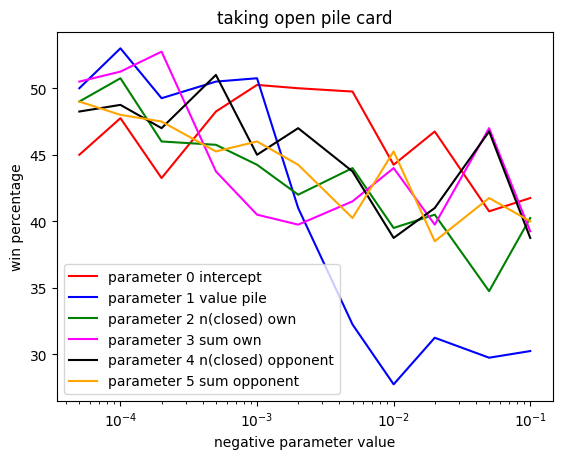

In [7]:
plt.plot(compm[0,:],100*compm[1,:],color='red',label='parameter 0 intercept') 
plt.plot(compm[0,:],100*compm[2,:],color='blue',label='parameter 1 value pile') 
plt.plot(compm[0,:],100*compm[3,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compm[0,:],100*compm[4,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compm[0,:],100*compm[5,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compm[0,:],100*compm[6,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("negative parameter value")
plt.ylabel("win percentage")
plt.title("taking open pile card")

As expected it is mostly the reverse of taking positive actions. Most deviations of it are likely chance. The same is visible below

Text(0.5, 1.0, 'discarding closed pile card')

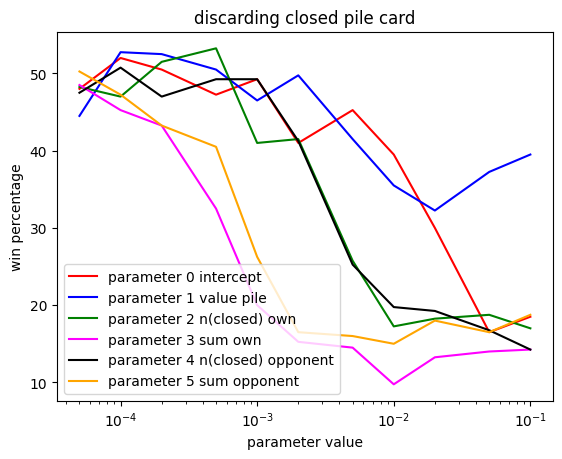

In [8]:

plt.plot(compm[0,:],100*compm[7,:],color='red',label='parameter 0 intercept') 
plt.plot(compm[0,:],100*compm[8,:],color='blue',label='parameter 1 value pile') 
plt.plot(compm[0,:],100*compm[9,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compm[0,:],100*compm[10,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compm[0,:],100*compm[11,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compm[0,:],100*compm[12,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("discarding closed pile card")

Text(0.5, 1.0, 'playing closed or maximum value')

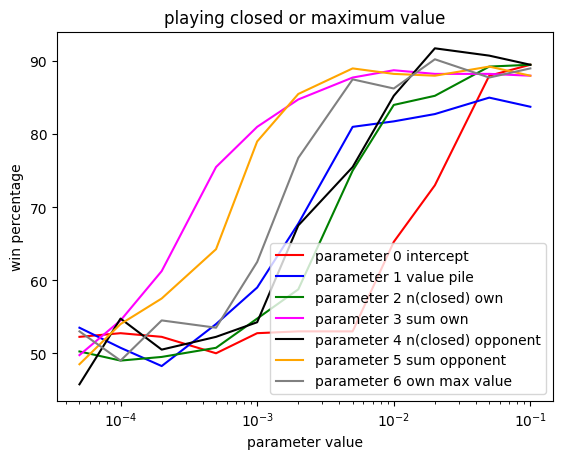

In [9]:
plt.plot(compm[0,:],100*compm[13,:],color='red',label='parameter 0 intercept') 
plt.plot(compm[0,:],100*compm[14,:],color='blue',label='parameter 1 value pile') 
plt.plot(compm[0,:],100*compm[15,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compm[0,:],100*compm[16,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compm[0,:],100*compm[17,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compm[0,:],100*compm[18,:],color='orange',label='parameter 5 sum opponent') 
plt.plot(compm[0,:],100*compm[19,:],color='gray',label='parameter 6 own max value') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("playing closed or maximum value")

Nowe combining the two and then fitting them with a function to get an estiamte of the variable range which is not so dependent on random varaiation than just using the maximum range. 

In [54]:
#x0 is fixed on 0 because that is the case floor added
def logistic_adapted(x,a,b,c):
    return a/(1+np.exp(-b*x))+c

In [55]:
print(logistic_adapted(-2,100,10,5))

5.000000206115362


In [36]:
compa=np.zeros((compm.shape[0],compm.shape[1]+compp.shape[1]))
compm=np.flip(compm,1)
compp=np.flip(compp,1)
compa[0,0:compm.shape[1]]=-compm[0]
compa[1:20,0:compm.shape[1]]=compm[1:20]
compa[:,compm.shape[1]:compa.shape[1]]=compp
print(compa[0])

[-1.e-01 -5.e-02 -2.e-02 -1.e-02 -5.e-03 -2.e-03 -1.e-03 -5.e-04 -2.e-04
 -1.e-04 -5.e-05  5.e-05  1.e-04  2.e-04  5.e-04  1.e-03  2.e-03  5.e-03
  1.e-02  2.e-02  5.e-02  1.e-01  2.e-01  5.e-01  1.e+00]


In [97]:
logpar=np.zeros((4,19))
ares=np.zeros((19,compa.shape[1]))
for i in range(19):
    popt, pcov = curve_fit(logistic_adapted, compa[0,:], 100*compa[1+i,:])
    print(popt)
    logpar[0:3,i]=popt
    fres=np.zeros((compa.shape[1]))
    for j in range(res.shape[0]):
        fres[j]=logistic_adapted(compa[0,j],popt[0],popt[1],popt[2])
    print(fres)     
    ares[i,:]=fres

[18.6247748  69.53617995 40.39012679]
[40.4078997  40.94848519 44.10190032 46.58922249 48.09975751 49.05600802
 49.37887067 49.54064354 49.63776045 49.67013693 49.68632551 49.71870287
 49.73489145 49.76726793 49.86438485 50.02615772 50.34902036 51.30527087
 52.81580589 55.30312807 58.45654319 58.99712869 59.0148846  59.01490159
 59.01490159]
[ -37.48500009 -536.97088872   69.12340004]
[31.63839995 31.63839995 31.63921237 31.81210219 34.03267929 41.18411229
 45.46633578 47.87986158 49.37544848 49.87781203 50.12931068 50.6324893
 50.88398796 51.38635151 52.88193841 55.29546421 59.5776877  66.72912069
 68.9496978  69.12258762 69.12340004 69.12340004 69.12340004 69.12340004
 69.12340004]
[ 18.39355488 739.43926106  39.55960927]
[39.55960927 39.55960927 39.55961622 39.57090865 40.00460679 42.97339551
 45.50305932 47.07537711 48.0775776  48.41651864 48.58639461 48.9263788
 49.09625478 49.43519581 50.4373963  52.00971409 54.5393779  57.50816663
 57.94186476 57.9531572  57.95316415 57.95316415

/tmp/ipykernel_4778/3323873085.py:3: RuntimeWarning: overflow encountered in exp
  return a/(1+np.exp(-b*x))+c


Text(0.5, 1.0, 'first parameter')

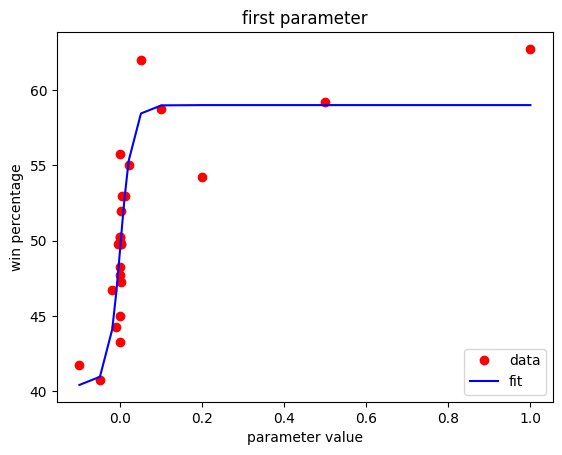

In [64]:
plt.plot(compa[0,:],100*compa[1,:],'o',color='red',label='data') 
plt.plot(compa[0,:],ares[0,:],color='blue',label='fit') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("first parameter")
#plt.xlim(-0.01,0.01)

Text(0.5, 1.0, 'parameter 18')

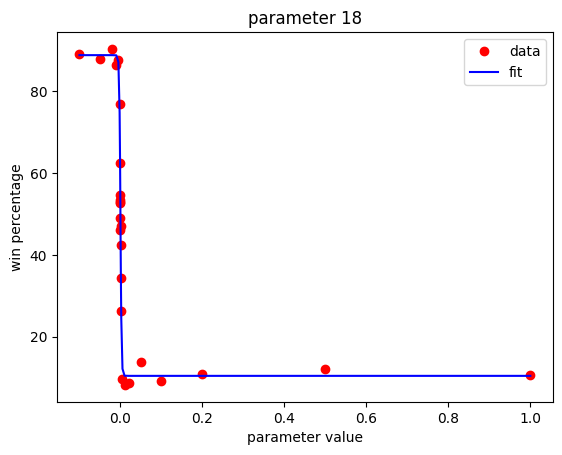

In [85]:
x=18
plt.plot(compa[0,:],100*compa[1+x,:],'o',color='red',label='data') 
plt.plot(compa[0,:],ares[x,:],color='blue',label='fit') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title(f"parameter {x}")
#plt.xlim(-0.01,0.01)

(-0.01, 0.01)

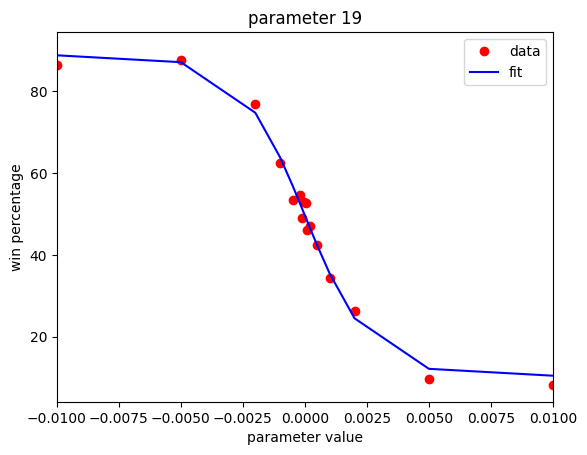

In [86]:
plt.plot(compa[0,:],100*compa[19,:],'o',color='red',label='data') 
plt.plot(compa[0,:],fres,color='blue',label='fit') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("parameter 19")
plt.xlim(-0.01,0.01)

Wanted as input for gradient fit on which scale half od the maximum posisble change happens. 

0.7502601055951177
0.7502601055951177
scale of changes
[ 0.0158191  -0.00204853  0.00148761  0.00037849  0.00427198  0.00074695
  0.01560032  0.00428962  0.00346228  0.00054269  0.00338403  0.00063986
 -0.01458805 -0.00189782 -0.00378486 -0.00044737 -0.00318601 -0.00058577
 -0.00144786]


(-0.003384028726511486, 0.003384028726511486)

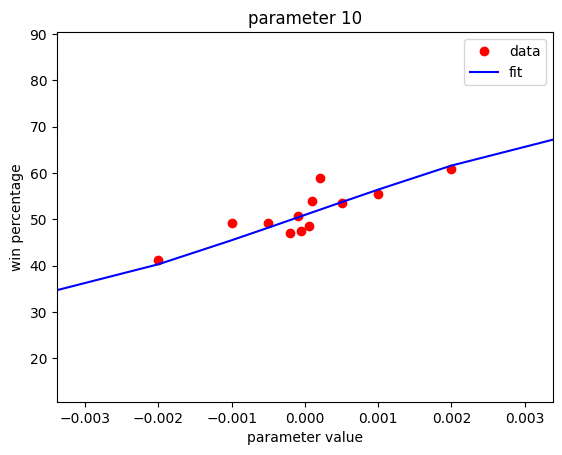

In [116]:
#for standard parameters
print(logistic_adapted(1.10,1,1,0))
#divide by b the rest does not matter
print(logistic_adapted(1.10/2,1,2,0))
logpar[3]=1.1/logpar[1]
print("scale of changes")
print(logpar[3])
x=10
plt.plot(compa[0,:],100*compa[1+x,:],'o',color='red',label='data') 
plt.plot(compa[0,:],ares[x,:],color='blue',label='fit') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title(f"parameter {x}")
plt.xlim(-logpar[3,x],logpar[3,x])

As another exploring method, I now constract a Monte Carlo procedure.
As the first step I create the function montecarlo_trials.
It takes lists of several model parameters as input. These are the levels 20. It plays against those by creating Monte Cralo model, the levels 21. They  are created randomly with given ranges. It creates a given number of of Monte Cralo trails, each with the same number of game realizations. 

In [10]:
#does Monte carlo against a number of cases
#open_vars and co and and are lists of the variables to be used 
#open_ranges and discard_ranges are 2,6 np arrays, value_ranges is 2,7 np array, 
#reliazations are number of models tried in one, trials are number of MC models for level 21
def montecarlo_trials(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials):
    n_it=realizations
    results=np.zeros((40,trials,len(open_vars)))
    for j in range(trials):
        print(f"doing Monte Carlo {j} for level 21")
        #create random values for level 21 within the ranges, save are used for all level 20 models
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        for k in range(7):
            level21_value_variable[k]=value_ranges[0,k]+random.random()*(value_ranges[1,k]-value_ranges[0,k])
            if k<6:
                level21_open_variable[k]=open_ranges[0,k]+random.random()*(open_ranges[1,k]-open_ranges[0,k])
                level21_discard_variable[k]=discard_ranges[0,k]+random.random()*(discard_ranges[1,k]-discard_ranges[0,k])
        for k in range(len(open_vars)):
            print(f"trying case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])             
            print(np.round(level21_open_variable,5),np.round(level21_discard_variable,5),np.round(level21_value_variable,5))
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            start_time=time.time()
            for i in range(n_it):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1
            results[38,j,k]=n_it
            results[39,j,k]=win20
            stop_time=time.time()
            print(f"{n_it} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(win20*100/n_it,1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[39,j,:])*100/n_it,1)} %")   
    return results 

Now  I am testing the function.

In [17]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0))]
list_discard=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0))]
list_value=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0))]


res=montecarlo_trials(list_open,list_discard,list_value,op_range,dis_range,val_range,50,4)
np.save("mc_v3.npy",res)

doing Monte Carlo 0 for level 21
trying case 0 for level 20
[-0.04679 -0.08825  0.01073 -0.05236  0.04742  0.04028] [-0.09838 -0.03574  0.00178 -0.07373 -0.02169  0.05731] [ 0.01207  0.00757 -0.00177  0.05194  0.0767  -0.08258  0.03525]
50 games need 3.669 seconds
level 20 won to 4.0 %
trying case 1 for level 20
[-0.04679 -0.08825  0.01073 -0.05236  0.04742  0.04028] [-0.09838 -0.03574  0.00178 -0.07373 -0.02169  0.05731] [ 0.01207  0.00757 -0.00177  0.05194  0.0767  -0.08258  0.03525]
50 games need 3.019 seconds
level 20 won to 0.0 %
trying case 2 for level 20
[-0.04679 -0.08825  0.01073 -0.05236  0.04742  0.04028] [-0.09838 -0.03574  0.00178 -0.07373 -0.02169  0.05731] [ 0.01207  0.00757 -0.00177  0.05194  0.0767  -0.08258  0.03525]
50 games need 2.064 seconds
level 20 won to 2.0 %
trying case 3 for level 20
[-0.04679 -0.08825  0.01073 -0.05236  0.04742  0.04028] [-0.09838 -0.03574  0.00178 -0.07373 -0.02169  0.05731] [ 0.01207  0.00757 -0.00177  0.05194  0.0767  -0.08258  0.03525]
5

Below I plot an example. 

Text(0, 0.5, 'level 20 wins [%]')

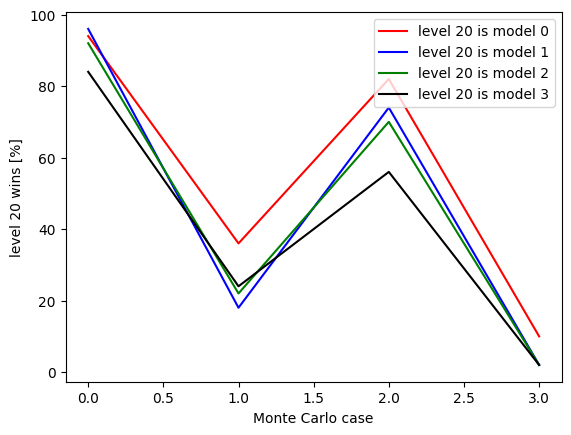

In [11]:
res3=np.load("mc_v2.npy")
plt.plot(range(4),res3[39,:,0]/res3[38,:,0]*100,color='red',label='level 20 is model 0') 
plt.plot(range(4),res3[39,:,1]/res3[38,:,0]*100,color='blue',label='level 20 is model 1') 
plt.plot(range(4),res3[39,:,2]/res3[38,:,0]*100,color='green',label='level 20 is model 2') 
plt.plot(range(4),res3[39,:,3]/res3[38,:,0]*100,color='black',label='level 20 is model 3') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("Monte Carlo case")
plt.ylabel("level 20 wins [%]")

Rather easy to improve compared to the current models. Below I print the parameters of the best case that they can be easily used for human trial. 

In [12]:
print(res3[19:25,3,2])
print(res3[25:31,3,2])
print(res3[31:38,3,2])

[ 0.01940094  0.05146526 -0.02648223 -0.07416882 -0.00188127 -0.01222425]
[ 0.07948311  0.05037697  0.00790461 -0.03574202  0.01697387 -0.05714196]
[-0.05759114  0.07014045 -0.05425065  0.09631128 -0.06878424 -0.00164203
  0.08420359]


As another test I include this model in the list of input models. It should clearly harder to win against this one. 

In [18]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open2=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0)),res3[19:25,3,2]]
list_discard2=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0)),res3[25:31,3,2]]
list_value2=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0)),res3[31:38,3,2]]

res2=montecarlo_trials(list_open2,list_discard2,list_value2,op_range,dis_range,val_range,50,5)
np.save("mc_v6.npy",res2)

doing Monte Carlo 0 for level 21
trying case 0 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]
50 games need 3.768 seconds
level 20 won to 38.0 %
trying case 1 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]
50 games need 2.397 seconds
level 20 won to 4.0 %
trying case 2 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]
50 games need 2.451 seconds
level 20 won to 24.0 %
trying case 3 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]

Below I plot the winning percentages of these comparisons. 

Text(0, 0.5, 'level 20 wins [%]')

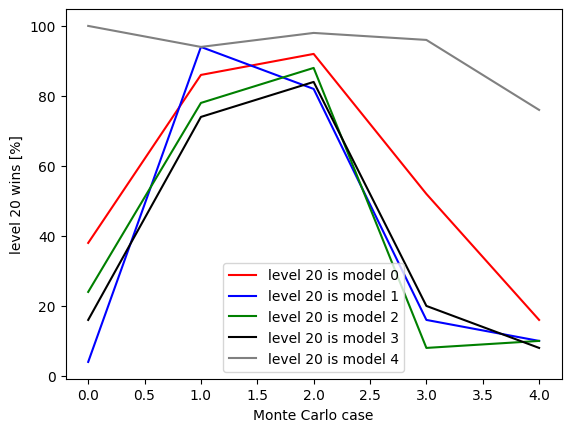

In [13]:
res2=np.load("mc_v6.npy")
plt.plot(range(5),res2[39,:,0]/res2[38,:,0]*100,color='red',label='level 20 is model 0') 
plt.plot(range(5),res2[39,:,1]/res2[38,:,0]*100,color='blue',label='level 20 is model 1') 
plt.plot(range(5),res2[39,:,2]/res2[38,:,0]*100,color='green',label='level 20 is model 2') 
plt.plot(range(5),res2[39,:,3]/res2[38,:,0]*100,color='black',label='level 20 is model 3') 
plt.plot(range(5),res2[39,:,4]/res2[38,:,0]*100,color='gray',label='level 20 is model 4')
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("Monte Carlo case")
plt.ylabel("level 20 wins [%]")

As expected the latest model (model 4) performs clearly better than the other models. 

Now I am changing the function somewhat to make it faster by stopping it early when either a good model is found 
or a Monte Carlo realization is clearly (not) an improvement. Below I first calculate how iterations are at least needed, that a test whether the fit is clear bad/good makes sense. I excluded cases which to 98% not from a Gaussian distribution on both sides that correspinds to 2.33 sigma. 

In [15]:
x=100
sig=(0-x/2)/np.sqrt(x)
print(sig)
#sig**2=(x**2)/4/x
#sig**2=x/4
sig2=2.33
x2=(sig2**2)*4
print(x2)


-5.0
21.715600000000002


The results if that for n greater equal 22 a significance test makes sense. This number is larger enough that using the Gaussian approxiamtions for a a in principel bionamial varaible is good enough that differences don't matter in practice. 

In [14]:
#does Monte carlo against a number of cases
#open_vars and co and and are lists of the variables to be used 
#open_ranges and discard_ranges are 2,6 np arrays, value_ranges is 2,7 np array, 
#reliazations are number of models tried in one, trials are number of MC models for level 21
#wfrac when it aborts early
#wfrac2 performance of worst case .
def montecarlo_trials2(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials,wfrac=0.10,wfrac2=0.551):
    n_it=realizations
    results=np.zeros((41,trials,len(open_vars)))
    for j in range(trials):
        print(f"doing Monte Carlo {j} for level 21")
        #create random values for level 21 within the ranges, save are used for all level 20 models
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        for k in range(7):
            level21_value_variable[k]=value_ranges[0,k]+random.random()*(value_ranges[1,k]-value_ranges[0,k])
            if k<6:
                level21_open_variable[k]=open_ranges[0,k]+random.random()*(open_ranges[1,k]-open_ranges[0,k])
                level21_discard_variable[k]=discard_ranges[0,k]+random.random()*(discard_ranges[1,k]-discard_ranges[0,k])
        for k in range(len(open_vars)):
            print(f"trying case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])             
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            it_counter=0
            start_time=time.time()
            n_it1=n_it
            if n_it1>22:
                n_it1=22
            #22 always     
            for i in range(n_it1):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                it_counter+=1
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1
            #98% ownside win conditions tested here   2.33 sigma   stops early when new model clearly bad or good 
            while it_counter<n_it and abs((win20-it_counter/2)/np.sqrt(it_counter))<2.33:  
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                it_counter+=1
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1                
            #now checking whether 98% sigficant on bad performance        
            results[38,j,k]=it_counter
            results[39,j,k]=win20
            results[40,j,k]=100*win20/it_counter         
            stop_time=time.time()
            print(f"{it_counter} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(results[40,j,k],1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[40,j,:]),1)} %") 
        if np.mean(results[40,j,:]/100)<wfrac and np.max(results[40,j,:]/100)<wfrac2:
            print("better model found")
            if j==0:
                return True, results[:,j,:], results[:,j,:]
            else:
                #give back fit converged or not, best models, all models 
                return True, results[:,j,:], results[:,0:j+1,:]
    print("no better model found") 
    #second parameter is noen will not be used later
    return False, None, results 

Now I am running for a test.

In [16]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

#load past iteration
with open('mc_v5_list_open.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_open5 = pickle.load(f)   
with open('mc_v5_list_discard.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_discard5 = pickle.load(f)  
with open('mc_v5_list_value.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_value5 = pickle.load(f)      
print(list_open5)
print(list_discard5)
print(list_value5)

start_time=time.time()
boolean,bestres,allres=montecarlo_trials2(list_open5,list_discard5,list_value5,op_range,dis_range,val_range,50,10,wfrac=0.001,wfrac2=0.002)
#v8/v9 on purpose impossible crieteria to just run all iterations with predictable operation duration
#now now changed
np.save("mc_v9b_all.npy",allres)
stop_time=time.time()
print(f"ran for {np.round(stop_time-start_time,2)} seconds")
#v8 20 trials need 418 second thus one trial need 21 seconds, 850 needed ran for 19897.58 seconds

[array([ 0.01940094,  0.05146526, -0.02648223, -0.07416882, -0.00188127,
       -0.01222425]), array([ 0.06411199, -0.06714365, -0.06118923, -0.07942706,  0.00706517,
       -0.09106071]), array([-0.03454234, -0.07293471,  0.03456145, -0.08240488, -0.01995018,
        0.01688238]), array([-0.03837573, -0.03494162,  0.06913455, -0.02994554,  0.00301286,
        0.00258103]), array([ 0.08420437,  0.01523879, -0.04838138,  0.04800721, -0.0470724 ,
       -0.09039604]), array([ 0.04234292, -0.07189049, -0.06083353,  0.06398506,  0.05762561,
       -0.06334734])]
[array([ 0.07948311,  0.05037697,  0.00790461, -0.03574202,  0.01697387,
       -0.05714196]), array([ 0.08944088,  0.0080087 ,  0.09545899, -0.06307576, -0.02390966,
        0.01762127]), array([ 0.05187052, -0.04812191,  0.05987011, -0.09685987, -0.03279703,
       -0.06690501]), array([-0.06190827,  0.00287039,  0.09979345, -0.05605547,  0.04381588,
        0.02095178]), array([-0.04095933,  0.02911903,  0.05907581, -0.06453082,

NameError: name 'montecarlo_trials2' is not defined

Below I am printing the output for a test. 

In [15]:
allres=np.load("mc_v8_all.npy")
print("win % of level 20, mean over different level 20")
print(np.round(np.mean(allres[40,:,:],0),3))
print("win % of level 20, mean over different level 21")
print(np.round(np.mean(allres[40,:,:],1),3))

win % of level 20, mean over different level 20
[86.696 90.739 91.577 91.065 94.131 94.505]
win % of level 20, mean over different level 21
[100.     91.747  98.077  98.077  96.866  33.185  90.177  97.607  97.276
 100.     93.529  92.897 100.    100.    100.     91.248  98.077  97.436
  55.     97.844]


Since model 20 is iteratively improved it should getter, and this is the case against the random model 21 here. 
In contrast the different Monte Carlos (model 21) there is no improve,ent and in most case level 20 is better. 

In [63]:
allres2=np.load("mc_v9_all.npy")
print("win % of level 20, mean over different level 20")
print(np.round(np.mean(allres2[40,:,:],0),3))
c=0
list_open7=[]
list_discard7=[]
list_value7=[]
for i in range(850):
    if np.mean(allres2[40,i,4:6])<45 and np.max(allres2[40,i,:])<60:
        print(allres2[40,i,:])
        list_open7.append(allres2[19:25,i,0])
        list_discard7.append(allres2[25:31,i,0])        
        list_value7.append(allres2[31:38,i,0]) 
        if np.mean(allres2[40,i,4:6])<30:
            print(allres2[19:25,i,0])
            print(allres2[25:31,i,0])      
            print(allres2[31:38,i,0])          
            print(np.mean(allres2[40,i,:]))
        c+=1
print(c)        
print(list_open7)
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

start_time=time.time()
boolean,bestres,allres=montecarlo_trials2(list_open7,list_discard7,list_value7,op_range,dis_range,val_range,50,2,wfrac=0.001,wfrac2=0.002)
#v10 on purpose impossible crieteria to just run all iterations with predictable operation duration
np.save("mc_v10b_all.npy",allres)
stop_time=time.time()
print(f"ran for {np.round(stop_time-start_time,2)} seconds")
#v8 20 trials need second   from (8*3600/(346/20)*(21/(19898/850))) follows 1493 trials

win % of level 20, mean over different level 20
[88.469 89.841 90.557 92.211 95.397 94.818]
[11.11111111 30.         16.32653061 28.         28.         50.        ]
[22. 22. 24. 28. 54. 18.]
[ 6.66666667 24.         11.11111111 26.         34.         46.        ]
[22. 22. 22. 18. 36. 20.]
[-0.06021169 -0.0902781  -0.00155455 -0.01841127  0.01388234 -0.05260926]
[ 0.04392365  0.06372851  0.00895102 -0.03337745 -0.02530273 -0.01245152]
[-0.04173424  0.08223763 -0.03537622  0.00899935  0.00076008  0.00648293
 -0.01169367]
23.333333333333332
[11.11111111 24.          9.09090909 44.         36.         26.        ]
[24.         36.          3.84615385 20.         28.         28.        ]
[-6.53596770e-05 -6.90977851e-02  1.60961960e-02 -4.81552487e-03
 -7.62965770e-02 -1.97269779e-02]
[-0.08082592  0.06676512 -0.04384349 -0.05287561  0.04113271  0.0027597 ]
[-0.05080273  0.07236404  0.01826358  0.00383818 -0.09585997  0.037045
 -0.0452486 ]
23.307692307692307
6
[array([-0.06831686,  0.027

In [17]:
allres3=np.load("mc_v10_all.npy")
print(allres3.shape)
print("win % of level 20, mean over different level 20")
print(np.round(np.mean(allres3[40,:,:],0),3))
c=0
list_open8=[]
list_discard8=[]
list_value8=[]
for i in range(850):
    if np.mean(allres3[40,i,:])<45 and np.max(allres3[40,i,:])<60:
        print(allres3[40,i,:])
        list_open8.append(allres3[19:25,i,0])
        list_discard8.append(allres3[25:31,i,0])        
        list_value8.append(allres3[31:38,i,0])            
        print(i)
        c+=1
print(c)        
print(list_open8)

(41, 1490, 6)
win % of level 20, mean over different level 20
[96.699 96.435 97.84  97.137 95.297 96.597]
[44. 32. 46. 52. 36. 48.]
326
1
[array([-0.04478875, -0.03684177,  0.07464749,  0.0019649 , -0.03943901,
       -0.08213137])]


Only one better then, now I plot the models by perfomance. 

Text(0.5, 1.0, 'open parameters')

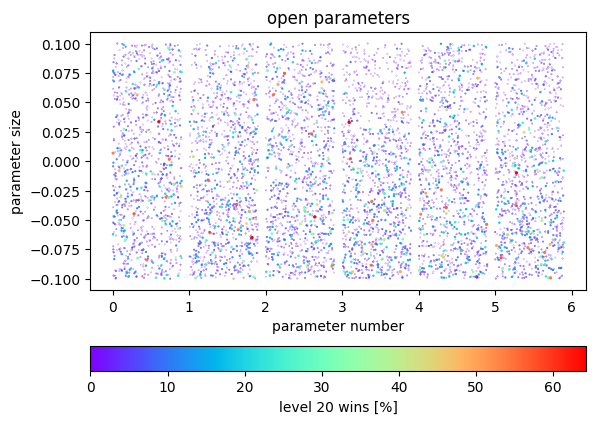

In [66]:
for_openplot=np.zeros((3,8940))
for_discardplot=np.zeros((3,8940))
for_valueplot=np.zeros((3,10430))
c=0
for j in range(allres3.shape[1]):
    for i in range(6):
        for_openplot[0,c]=i+random.random()*0.9
        for_openplot[2,c]=np.mean(allres3[40,j,:])            
        for_openplot[1,c]=allres3[19+i,j,0]
        c+=1            

c=0
for j in range(allres3.shape[1]):
    for i in range(6):
        for_discardplot[0,c]=i+random.random()*0.9
        for_discardplot[2,c]=np.mean(allres3[40,j,:])            
        for_discardplot[1,c]=allres3[25+i,j,0]
        c+=1      

c=0
for j in range(allres3.shape[1]):
    for i in range(7):
            for_valueplot[0,c]=i+random.random()*0.9
            for_valueplot[2,c]=np.mean(allres3[40,j,:])            
            for_valueplot[1,c]=allres3[31+i,j,0]
            c+=1      

plt.scatter(x=for_openplot[0], y=for_openplot[1], c=100-for_openplot[2],s=3-for_openplot[2]/100*3, cmap="rainbow")
plt.colorbar(label="level 20 wins [%]", orientation="horizontal")
plt.xlabel("parameter number")
plt.ylabel("parameter size")
plt.title("open parameters")

Text(0.5, 1.0, 'discard parameters')

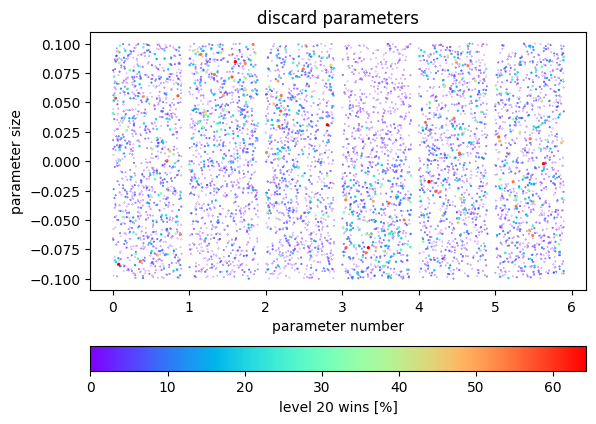

In [65]:

plt.scatter(x=for_discardplot[0], y=for_discardplot[1], c=100-for_discardplot[2],s=3-for_discardplot[2]/100*3, cmap="rainbow")
plt.colorbar(label="level 20 wins [%]", orientation="horizontal")
plt.xlabel("parameter number")
plt.ylabel("parameter size")
plt.title("discard parameters")

Text(0.5, 1.0, 'value parameters')

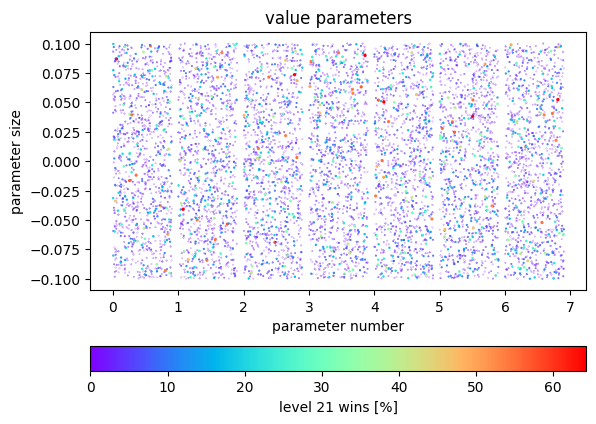

In [64]:
plt.scatter(x=for_valueplot[0], y=for_valueplot[1], c=100-for_valueplot[2],s=3-for_valueplot[2]/100*3, cmap="rainbow")
plt.colorbar(label="level 21 wins [%]", orientation="horizontal")
plt.xlabel("parameter number")
plt.ylabel("parameter size")
plt.title("value parameters")

It is not very easy to see which is better, there are some differences, but it shws that the pure Monte Carlo method reached its limit. 
Now I am building the Monte Carlo fitting function. 
  

First I create to helper functions to convert list of array output to numpy output.

In [18]:
#using input arrays of varaible shape[1] where the largest the the last one 
#only possible if there is one to add
def bestfit_to_array(list_best):
    if len(list_best)>0:
        last=list_best[len(list_best)-1]
        results=np.zeros((last.shape[0],last.shape[1],len(list_best)))
        #set not filled values to -100 to be clearly impossible
        results[:,:,:]=-100
        for i in range(len(list_best)):
            results[0:list_best[i].shape[0],0:list_best[i].shape[1],i]=list_best[i]
        return results  
    else:
        print("List is of length 0, no combination possible.")
        results=np.array([-100.])
        return results

Below I test the function. 

In [19]:
list2=[]
print(list2)
res=bestfit_to_array(list2)
print(res.shape,res)
list2=[np.zeros((41,5))]
print(list2[0].shape)
res=bestfit_to_array(list2)
print(res.shape)
list2=[np.zeros((6,5)),np.zeros((6,6))]
print(list2[0].shape)
res=bestfit_to_array(list2)
print(res.shape)

[]
List is of length 0, no combination possible.
(1,) [-100.]
(41, 5)
(41, 5, 1)
(6, 5)
(6, 6, 2)


Next the similar function which works on lists of 3d arrays. 

In [20]:
#works on list of 3d arrays, also of length 1 not of length 0, but that should not possible 
def allfits_to_array(list_all):
    if len(list_all)>0:
        dims=np.zeros((3,len(list_all)))
        for i in range(len(list_all)):
            dims[:,i]=list_all[i].shape
        results=np.zeros((int(max(dims[0,:])),int(max(dims[1,:])),int(max(dims[2,:])),len(list_all)))
        results[:]=-100  
        for i in range(len(list_all)):
            results[0:list_all[i].shape[0],0:list_all[i].shape[1],0:list_all[i].shape[2],i]=list_all[i]
        return results 
    else:
        print("List is of length 0, no combination possible.")
        results=np.array([-100.])
        return results

Below I test the function. 

In [21]:
list2=[]
print(list2)
res=allfits_to_array(list2)
print(res.shape,res)
list2=[np.zeros((41,5,2))]
print(list2[0].shape)
res=allfits_to_array(list2)
print(res.shape)
list2=[np.zeros((41,5,2)),np.zeros((40,4,3))]
print(list2[0].shape,list2[1].shape)
res=allfits_to_array(list2)
print(res.shape)

[]
List is of length 0, no combination possible.
(1,) [-100.]
(41, 5, 2)
(41, 5, 2, 1)
(41, 5, 2) (40, 4, 3)
(41, 5, 3, 2)


Now to the MonteCarlo fit function itself. 
It start with a list of input moel parameters and adds to it iteratively more models which perform at least somewhat better. If no such model is found the fit ends early.

In [22]:
#paarmeters, list of open parameters,  list of discard parameters, list of value parameters,
#open parameter ranges, discard parameter ranges, value parameter ranges,
#maximum number of games palyed for model pair. 
#Maximum number of Monte carlo pairs, 
#maxium number of added models tried,
#wfrac average maximum win fraction  for level 20, #wfrac2 maximum win fraction for single level 20 model
#both need to be smaller
def montecarlo_fit(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations=50,trials=10,max_iter=10,wfrac=0.10,wfrac2=0.5):
    #list to performances of winner models
    list_best_result=[]
    list_all_results=[]
    for i in range(max_iter):
        print(f"iteration {i} using {len(open_vars)} level 20 models")
        boolean,best_result,all_results=montecarlo_trials2(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials,wfrac=wfrac,wfrac2=wfrac2)
        # good model found
        if boolean==True:
            #append this model
            open_vars.append(best_result[19:25,0])
            discard_vars.append(best_result[25:31,0])
            value_vars.append(best_result[31:38,0])
            print("model to append found")
            print(f"best model won to {np.round(100-np.mean(best_result[40,:]),1)} %")
            list_best_result.append(best_result)
            list_all_results.append(all_results)
        else:
            #no better found, still data collected but not ;best model added'      
            print("no model to append found iterations stopped early")
            list_all_results.append(all_results)
            array_best_result=bestfit_to_array(list_best_result)
            array_all_results=allfits_to_array(list_all_results)    
            return open_vars, discard_vars, value_vars,array_best_result,array_all_results 
    print("all iterations done")
    #converting lists to arrays
    array_best_result=bestfit_to_array(list_best_result)
    array_all_results=allfits_to_array(list_all_results)    
    return open_vars, discard_vars, value_vars,array_best_result,array_all_results    
#should also put all model and to save performances 

Below I run, shown is a short run, longer were run and saved before. 

In [229]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

#load past iteration
with open('mc_v5_list_open.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_open5 = pickle.load(f)   
with open('mc_v5_list_discard.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_discard5 = pickle.load(f)  
with open('mc_v5_list_value.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_value5 = pickle.load(f)      
print(list_open5)
print(list_discard5)
print(list_value5)

#printing more than it should shape and best min 
start_time=time.time()
list_open3,list_discard3,list_value3,array_bestres3,array_allres3=montecarlo_fit(list_open5,list_discard5,list_value5,op_range,dis_range,val_range,realizations=50,trials=5,wfrac=0.45,max_iter=3,wfrac2=0.6)
np.save("mc_v6_list_res.npy",array_bestres3)
np.save("mc_v6_list_allres.npy",array_allres3)
with open('mc_v6_list_open.pkl', 'wb') as f:
    pickle.dump(list_open3, f, pickle.HIGHEST_PROTOCOL)
with open('mc_v6_list_discard.pkl', 'wb') as f:
    pickle.dump(list_discard3, f, pickle.HIGHEST_PROTOCOL)
with open('mc_v6_list_value.pkl', 'wb') as f:
    pickle.dump(list_value3, f, pickle.HIGHEST_PROTOCOL)    
stop_time=time.time()
print(f"ran for {np.round(stop_time-start_time,2)} seconds")


[array([ 0.01940094,  0.05146526, -0.02648223, -0.07416882, -0.00188127,
       -0.01222425]), array([ 0.06411199, -0.06714365, -0.06118923, -0.07942706,  0.00706517,
       -0.09106071]), array([-0.03454234, -0.07293471,  0.03456145, -0.08240488, -0.01995018,
        0.01688238]), array([-0.03837573, -0.03494162,  0.06913455, -0.02994554,  0.00301286,
        0.00258103]), array([ 0.08420437,  0.01523879, -0.04838138,  0.04800721, -0.0470724 ,
       -0.09039604]), array([ 0.04234292, -0.07189049, -0.06083353,  0.06398506,  0.05762561,
       -0.06334734])]
[array([ 0.07948311,  0.05037697,  0.00790461, -0.03574202,  0.01697387,
       -0.05714196]), array([ 0.08944088,  0.0080087 ,  0.09545899, -0.06307576, -0.02390966,
        0.01762127]), array([ 0.05187052, -0.04812191,  0.05987011, -0.09685987, -0.03279703,
       -0.06690501]), array([-0.06190827,  0.00287039,  0.09979345, -0.05605547,  0.04381588,
        0.02095178]), array([-0.04095933,  0.02911903,  0.05907581, -0.06453082,

Now loading past fits result. The loaded fit had not yet an extra condition on the best level 20 model. I make a plot on the win percentage

(41, 12, 8)
[-0.09923392  0.03984586  0.03498189 -0.00576379 -0.00164228 -0.03251231
  0.02618759 -0.08613913  0.06374869 -0.08448752 -0.02141158 -0.01957679
 -0.09295743  0.03691107  0.00654938  0.00254979  0.08551578  0.01504413
  0.09738389]
[-0.09923392  0.03984586  0.03498189 -0.00576379 -0.00164228 -0.03251231
  0.02618759 -0.08613913  0.06374869 -0.08448752 -0.02141158 -0.01957679
 -0.09295743  0.03691107  0.00654938  0.00254979  0.08551578  0.01504413
  0.09738389]
68
[ 5.  6.  7.  8.  9. 10. 11. 12.]


Text(0.5, 1.0, 'Model numbers are shared here')

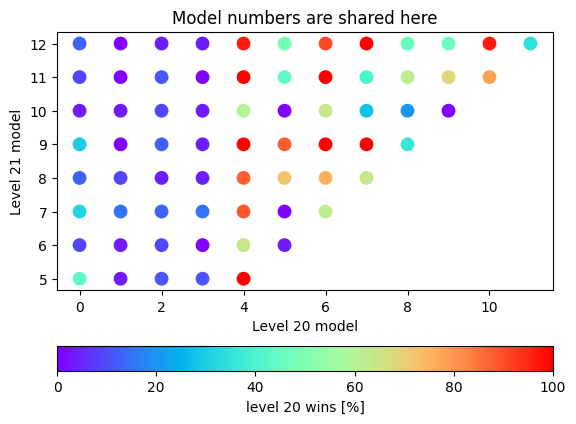

In [23]:
with open('mc_v1_list_res.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_res3b = pickle.load(f)   
res5=bestfit_to_array(list_res3b)
#below need to make to function best also consider for cases of model sharing 
grid = np.indices((res5[40,:,:].shape[0],res5[40,:,:].shape[1]))
print(res5.shape)
counter=0
vec=np.zeros((res5.shape[2]))
vec[:]=-1
print(res5[0:19,5,1])
print(res5[19:38,4,0])
for i in range(res5.shape[1]):
    for j in range(res5.shape[2]):
        if res5[40,i,j]>-1:
            counter+=1
            for k in range(res5.shape[1]):
                for l in range(res5.shape[2]):          
                    if np.sum(res5[0:19,i,j])==np.sum(res5[19:38,k,l]): 
                        vec[l]=i
print(counter)  
vec[vec.shape[0]-1]=vec[vec.shape[0]-2]+1
print(vec)
counter=0
results=np.zeros((4,68))   
for i in range(res5.shape[1]):
    for j in range(res5.shape[2]):
        if res5[40,i,j]>-1:
            results[0,counter]=i
            results[1,counter]=j
            results[2,counter]=vec[j]
            results[3,counter]=res5[40,i,j]
            counter+=1
#plt.plot(grid[0],grid[1],'o',color='red') 
plt.scatter(x=results[0], y=results[2], c=results[3,:],s=80, cmap="rainbow")
plt.colorbar(label="level 20 wins [%]", orientation="horizontal")
#plt.xscale("log")
plt.xlabel("Level 20 model")
plt.ylabel("Level 21 model")
plt.title("Model numbers are shared here")

It is visible that it is easy to be better than the models 0 to 3, for them at most one parameter is different from 0 models, but then it gets more difficult. 

Since these models are not particular good, they are now ignored. 

Below I load the model parameters of the currently acceptable models. 

6


Text(0.5, 1.0, 'open parameters')

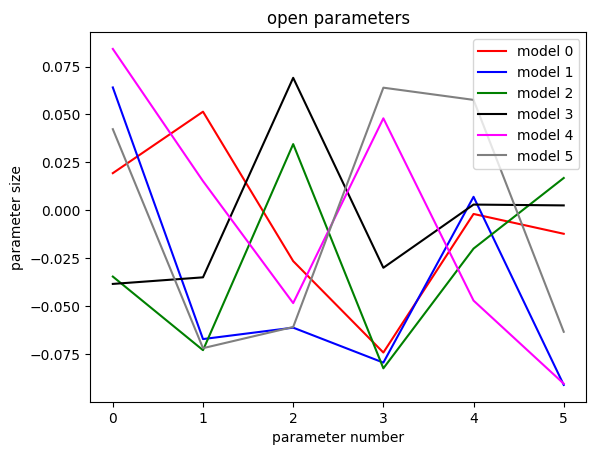

In [24]:
with open('mc_v5_list_open.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_open5 = pickle.load(f)   
with open('mc_v5_list_discard.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_discard5 = pickle.load(f)  
with open('mc_v5_list_value.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_value5 = pickle.load(f)  
print(len(list_open5))    
plt.plot(range(6),list_open5[0],color='red',label='model 0') 
plt.plot(range(6),list_open5[1],color='blue',label='model 1') 
plt.plot(range(6),list_open5[2],color='green',label='model 2') 
plt.plot(range(6),list_open5[3],color='black',label='model 3') 
plt.plot(range(6),list_open5[4],color='magenta',label='model 4')
plt.plot(range(6),list_open5[5],color='gray',label='model 5') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number")
plt.ylabel("parameter size")
plt.title("open parameters")

Text(0.5, 1.0, 'discard parameters')

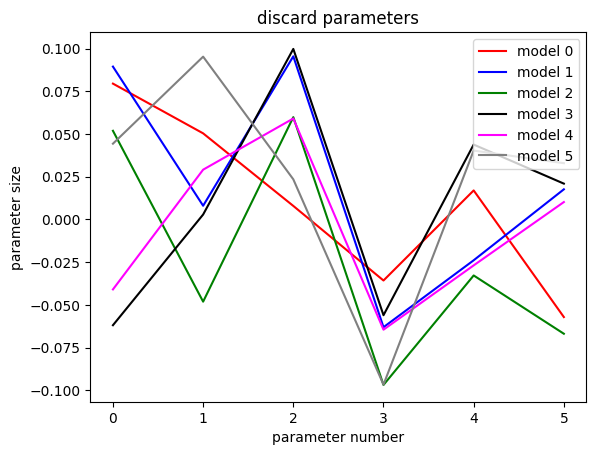

In [25]:
plt.plot(range(6),list_discard5[0],color='red',label='model 0') 
plt.plot(range(6),list_discard5[1],color='blue',label='model 1') 
plt.plot(range(6),list_discard5[2],color='green',label='model 2') 
plt.plot(range(6),list_discard5[3],color='black',label='model 3') 
plt.plot(range(6),list_discard5[4],color='magenta',label='model 4')
plt.plot(range(6),list_discard5[5],color='gray',label='model 5') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number")
plt.ylabel("parameter size")
plt.title("discard parameters")

Here in discard is the clearest preference, for 2 (number of own closed cards) for large and for 3 (sum of own open cards)for small.

Text(0.5, 1.0, 'value parameters')

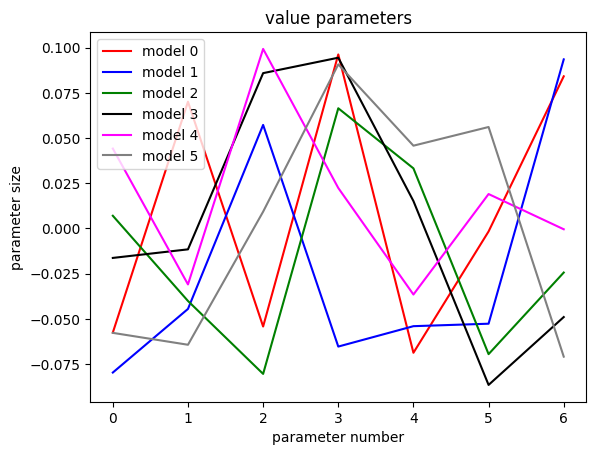

In [26]:
plt.plot(range(7),list_value5[0],color='red',label='model 0') 
plt.plot(range(7),list_value5[1],color='blue',label='model 1') 
plt.plot(range(7),list_value5[2],color='green',label='model 2') 
plt.plot(range(7),list_value5[3],color='black',label='model 3') 
plt.plot(range(7),list_value5[4],color='magenta',label='model 4')
plt.plot(range(7),list_value5[5],color='gray',label='model 5') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number")
plt.ylabel("parameter size")
plt.title("value parameters")

In [180]:
#gradient gets local gradient compared to input models (can be own but should several to avoid too
#much orienation to a single )
#input models open_vars,discard_vars,value_vars
#single model (can be mean or something else) around which steps are done open_avg,discard_avg,value_avg
#step size vectors to step to explore open_step,discard_step,value_step
#n_games number of games done for the exploring models, base model does more by fixed factor
def gradient_step1(open_vars,discard_vars,value_vars,open_avg,discard_avg,value_avg,open_step,discard_step,value_step,n_games):
    #always 20 because of doing 20 paaremeters separametely plus the base model
    results=np.zeros((41,20,len(open_vars)))
    for j in range(20):
        level21_open_variable=np.array(open_avg)
        level21_discard_variable=np.array(discard_avg)      
        level21_value_variable=np.array(value_avg)           
        if j==0:
            print(f"doing Base model")             
        #start now gradient with open 
        elif j<7:
            print(f"changing open variable {j-1}")  
            level21_open_variable[j-1]+=open_step[j-1]                 
        elif j<13:
            print(f"changing discard variable {j-7}")  
            level21_discard_variable[j-7]+=discard_step[j-7]
        else:
            print(f"changing value variable {j-13}")             
            level21_value_variable[j-13]+=value_step[j-13]        
        for k in range(len(open_vars)):
            print(f"doing case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])             
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            start_time=time.time()
            #4 times for often used based model
            if j==0:
                n_games_here=n_games*4
            else:
                n_games_here=n_games   
            for i in range(n_games_here):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1                    
            results[38,j,k]=n_games_here
            results[39,j,k]=win20
            results[40,j,k]=100*win20/n_games_here     
            stop_time=time.time()
            print(f"{n_games_here} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(results[40,j,k],1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[40,j,:]),1)} %") 
    print("all models done") 
    return results 

Now test run, it uses the model found in run 9 for it.  First 5 ae used as model to be compared with (level 20), the last one is the level 21 which is iteratively improved. 

In [181]:
def get_range(x_plus,y_plus,x_minus, y_minus):
    result=np.zeros((y_plus.shape[0]))
    for i in range(y_plus.shape[0]):
        if np.mean(y_plus[i,:])>np.mean(y_minus[i,:]):
            a=x_plus[np.argmax(y_plus[i,:])]
            if a>0.1:
                a=0.1
            b=compm[0,np.argmin(y_minus[i,:])]
            if b<-0.1:
                b=-0.1
            result[i]=(a+np.abs(b))/2    
        else:
            a=x_plus[np.argmin(y_plus[i,:])]
            if a>0.1:
                a=0.1
            b=compm[0,np.argmax(y_minus[i,:])]
            if b<-0.1:
                b=-0.1
            result[i]=(a+np.abs(b))/2  
    return result            
#get max ranges but not ideal since affected by small random wggles, still o.k. for now 

In [65]:
allres2=np.load("mc_v9_all.npy")
c=0
list_open7=[]
list_discard7=[]
list_value7=[]
for i in range(850):
    if np.mean(allres2[40,i,4:6])<45 and np.max(allres2[40,i,:])<60:
        list_open7.append(allres2[19:25,i,0])
        list_discard7.append(allres2[25:31,i,0])        
        list_value7.append(allres2[31:38,i,0]) 
        c+=1
print(f"{c} improved models found")        

list_open8=list_open7[0:5]
list_discard8=list_discard7[0:5]
list_value8=list_value7[0:5]        
open_steps2=get_range(compp[0,:],compp[1:7,:],compm[0,:],compm[1:7,:])
print(open_steps2)
discard_steps2=get_range(compp[0,:],compp[7:13,:],compm[0,:],compm[7:13,:])
print(discard_steps2)
value_steps2=get_range(compp[0,:],compp[13:20,:],compm[0,:],compm[13:20,:])
print(value_steps2)
#using only a prt for it 

6 improved models found
[0.075 0.055 0.075 0.075 0.055 0.06 ]
[0.075 0.02  0.1   0.015 0.1   0.055]
[0.1   0.05  0.1   0.055 0.06  0.075 0.015]


Now doing with 300, is a lot, but currently is time. Later I need to better figure the right step size, but first fits helps also. Could do in general first exploratory fit, but possibl;e when I once figure it out not more adjustments are needed.  

In [79]:
start_time=time.time()
n_games=100
resgrad1=gradient_step1(list_open8,list_discard8,list_value8,list_open7[5],list_discard7[5],list_value7[5],open_steps2/1,discard_steps2/1,value_steps2/1,n_games)
np.save("gradient_step1_v3.npy",resgrad1)
stop_time=time.time()
print(f"{n_games} games need {np.round(stop_time-start_time,3)} seconds")
#10 games need 252.826 seconds
#now mean running 1 , 2 not yet done 

doing Base model
trying case 0 for level 20
400 games need 96.264 seconds
level 20 won to 53.0 %
trying case 1 for level 20
400 games need 88.683 seconds
level 20 won to 50.0 %
trying case 2 for level 20
400 games need 99.333 seconds
level 20 won to 53.8 %
trying case 3 for level 20
400 games need 116.728 seconds
level 20 won to 55.8 %
trying case 4 for level 20
400 games need 103.205 seconds
level 20 won to 53.5 %
level 20 won in average to 53.2 %
changing open variable 0
trying case 0 for level 20
100 games need 26.672 seconds
level 20 won to 55.0 %
trying case 1 for level 20
100 games need 23.119 seconds
level 20 won to 42.0 %
trying case 2 for level 20
100 games need 21.655 seconds
level 20 won to 54.0 %
trying case 3 for level 20
100 games need 26.133 seconds
level 20 won to 57.0 %
trying case 4 for level 20
100 games need 28.656 seconds
level 20 won to 53.0 %
level 20 won in average to 52.2 %
changing open variable 1
trying case 0 for level 20
100 games need 32.216 seconds
level 

100 games need 24.787 seconds
level 20 won to 45.0 %
trying case 1 for level 20
100 games need 24.357 seconds
level 20 won to 44.0 %
trying case 2 for level 20
100 games need 23.076 seconds
level 20 won to 51.0 %
trying case 3 for level 20
100 games need 25.544 seconds
level 20 won to 56.0 %
trying case 4 for level 20
100 games need 26.047 seconds
level 20 won to 56.0 %
level 20 won in average to 50.4 %
changing value variable 6
trying case 0 for level 20
100 games need 26.889 seconds
level 20 won to 46.0 %
trying case 1 for level 20
100 games need 23.635 seconds
level 20 won to 46.0 %
trying case 2 for level 20
100 games need 22.845 seconds
level 20 won to 59.0 %
trying case 3 for level 20
100 games need 25.323 seconds
level 20 won to 43.0 %
trying case 4 for level 20
100 games need 26.936 seconds
level 20 won to 48.0 %
level 20 won in average to 48.4 %
all models done
100 games need 2589.81 seconds


Now running with the ranges gotten in logistic fit. The aim changes are 75%/25% since beyound that the gradient gets clearly smaller and for smaller percentages the shot noise gets more important.

In [182]:
allres2=np.load("mc_v9_all.npy")
c=0
list_open7=[]
list_discard7=[]
list_value7=[]
for i in range(850):
    if np.mean(allres2[40,i,4:6])<45 and np.max(allres2[40,i,:])<60:
        list_open7.append(allres2[19:25,i,0])
        list_discard7.append(allres2[25:31,i,0])        
        list_value7.append(allres2[31:38,i,0]) 
        c+=1
print(f"{c} improved models found")        
print("5 used to to test against")
list_open8=list_open7[0:5]
list_discard8=list_discard7[0:5]
list_value8=list_value7[0:5]        
open_steps2=logpar[3,0:6]
print("used steps are")
print(open_steps2)
discard_steps2=logpar[3,6:12]
print(discard_steps2)
value_steps2=logpar[3,12:19]
print(value_steps2)

start_time=time.time()
n_games=100
resgrad1=gradient_step1(list_open8,list_discard8,list_value8,list_open7[5],list_discard7[5],list_value7[5],-open_steps2/1,-discard_steps2/1,-value_steps2/1,n_games)
#456 it not use right method for discard and value step
np.save("gradient_step1_v7.npy",resgrad1)
stop_time=time.time()
print(f"{n_games} games need {np.round(stop_time-start_time,3)} seconds")

6 improved models found
5 used to to test against
used steps are
[ 0.0158191  -0.00204853  0.00148761  0.00037849  0.00427198  0.00074695]
[0.01560032 0.00428962 0.00346228 0.00054269 0.00338403 0.00063986]
[-0.01458805 -0.00189782 -0.00378486 -0.00044737 -0.00318601 -0.00058577
 -0.00144786]
doing Base model
doing case 0 for level 20
400 games need 106.654 seconds
level 20 won to 53.8 %
doing case 1 for level 20
400 games need 102.918 seconds
level 20 won to 46.8 %
doing case 2 for level 20
400 games need 99.907 seconds
level 20 won to 55.5 %
doing case 3 for level 20
400 games need 128.84 seconds
level 20 won to 56.2 %
doing case 4 for level 20
400 games need 141.022 seconds
level 20 won to 54.2 %
level 20 won in average to 53.3 %
changing open variable 0
doing case 0 for level 20
100 games need 30.689 seconds
level 20 won to 56.0 %
doing case 1 for level 20
100 games need 28.399 seconds
level 20 won to 48.0 %
doing case 2 for level 20
100 games need 26.807 seconds
level 20 won to 48

100 games need 28.604 seconds
level 20 won to 53.0 %
doing case 3 for level 20
100 games need 31.383 seconds
level 20 won to 47.0 %
doing case 4 for level 20
100 games need 34.628 seconds
level 20 won to 45.0 %
level 20 won in average to 48.0 %
changing value variable 5
doing case 0 for level 20
100 games need 32.091 seconds
level 20 won to 50.0 %
doing case 1 for level 20
100 games need 32.021 seconds
level 20 won to 43.0 %
doing case 2 for level 20
100 games need 29.677 seconds
level 20 won to 55.0 %
doing case 3 for level 20
100 games need 31.241 seconds
level 20 won to 53.0 %
doing case 4 for level 20
100 games need 33.949 seconds
level 20 won to 57.0 %
level 20 won in average to 51.6 %
changing value variable 6
doing case 0 for level 20
100 games need 33.81 seconds
level 20 won to 41.0 %
doing case 1 for level 20
100 games need 29.727 seconds
level 20 won to 48.0 %
doing case 2 for level 20
100 games need 30.909 seconds
level 20 won to 49.0 %
doing case 3 for level 20
100 games ne

[52.45       52.26666667 50.33333333 51.2        51.         51.06666667
 52.4        48.66666667 95.46666667 45.46666667 95.4        65.8
 48.         51.6        57.06666667 50.26666667 51.26666667 52.13333333
 52.53333333 46.86666667]


Text(0.5, 1.0, 'all parameters')

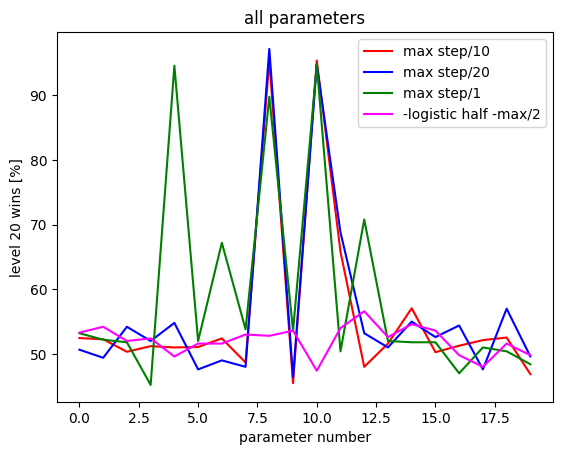

In [183]:
resgrad1=np.load("gradient_step1_v1.npy")
resgrad2=np.load("gradient_step1_v2.npy")
resgrad3=np.load("gradient_step1_v3.npy")
resgrad4=np.load("gradient_step1_v4.npy")
resgrad5=np.load("gradient_step1_v5.npy")
resgrad7=np.load("gradient_step1_v7.npy")
#all from 1 to 6 used wrong step size for discard and value
print(np.mean(resgrad1[40,:,:],1))
plt.plot(range(20),np.mean(resgrad1[40,:,:],1),color='red',label='max step/10') 
plt.plot(range(20),np.mean(resgrad2[40,:,:],1),color='blue',label='max step/20') 
plt.plot(range(20),np.mean(resgrad3[40,:,:],1),color='green',label='max step/1') 
#plt.plot(range(20),np.mean(resgrad4[40,:,:],1),color='black',label='logistic max/2') 
plt.plot(range(20),np.mean(resgrad7[40,:,:],1),color='magenta',label='-logistic half -max/2') 
#plt.plot(range(20),np.mean(resgrad6[40,:,:],1),color='gray',label='-logistic half -max/4') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number")
plt.ylabel("level 20 wins [%]")
plt.title("all parameters")


Most changes are very small and likely chance. Now I build a function how to use the information found before to find the next parameters which should be tried. 

In [211]:
#gets new parameters
#and step sizes
def get_new_parameters(result):
    new_par=np.zeros(19)
    new_steps=np.zeros(19)
    for i in range(1,20):
        err=100*np.sqrt(np.sum(result[38,i,:])/np.sum(result[38,i,:])**2+np.sum(result[38,0,:])/np.sum(result[38,0,:])**2)
        diff=np.mean(result[40,i,:])-np.mean(result[40,0,:])
        #if really bad results or if significance less than 1 just use current base values 
        if np.mean(result[40,i,:])>75 or abs(diff/err)<1:
            new_par[i-1]=result[18+i,0,0]
            if abs(diff/err)<1:
                #direction cannot be known in thisc case increase it and change sign randomly
                new_steps[i-1]=3*(result[18+i,i,0]-result[18+i,0,0])*np.sign(random.random()-0.5)
            elif np.mean(result[40,i,:])<87:
                #reverse direction and less
                new_steps[i-1]=-1/3*(result[18+i,i,0]-result[18+i,0,0])
                #use old base for all versions
            elif np.mean(result[40,i,:])<94:
                new_steps[i-1]=-1/5*(result[18+i,i,0]-result[18+i,0,0])                 
            elif np.mean(result[40,i,:])<97:
                new_steps[i-1]=-1/9*(result[18+i,i,0]-result[18+i,0,0])             
            else:
                new_steps[i-1]=-1/17*(result[18+i,i,0]-result[18+i,0,0])               
        #else use the tried step possible times -1    
        else:
            new_par[i-1]=result[18+i,0,0]+(-result[18+i,i,0]+result[18+i,0,0])*np.sign(diff)
            if abs(diff/err)<3:
                #somewhat smaller in this case, diff/err gives direction needed when diff positive 
                new_steps[i-1]=-3/(diff/err)*(result[18+i,i,0]-result[18+i,0,0])
            else:    
                new_steps[i-1]=-1/np.sign(diff/err)*(result[18+i,i,0]-result[18+i,0,0])                
    return new_par,new_steps       

In [191]:
#was done with old faulty but not much matter since signs small
new_par1,new_step1=get_new_parameters(resgrad7)
print("difference between new and old parameters")
print(new_par1-resgrad6[19:38,0,0])
print("factor between old and new steps")
print(new_step1/logpar[3,:])

difference between new and old parameters
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.00054269  0.          0.
  0.          0.          0.          0.          0.00318601  0.
  0.        ]
factor between old and new steps
[-3.         -3.         -3.         -3.         -3.         -3.
 -3.         -3.         -3.          2.54237288 -3.         -3.
 -3.         -3.         -3.         -3.          2.83018868 -3.
 -3.        ]


Now I use the new parameters and steps for another fit. 

In [192]:
allres2=np.load("mc_v9_all.npy")
c=0
list_open7=[]
list_discard7=[]
list_value7=[]
for i in range(850):
    if np.mean(allres2[40,i,4:6])<45 and np.max(allres2[40,i,:])<60:
        list_open7.append(allres2[19:25,i,0])
        list_discard7.append(allres2[25:31,i,0])        
        list_value7.append(allres2[31:38,i,0]) 
        c+=1
print(f"{c} improved models found")        
print("5 used to to test against")
list_open8=list_open7[0:5]
list_discard8=list_discard7[0:5]
list_value8=list_value7[0:5]        
open_steps3=new_step1[0:6]
print("used steps are")
print(open_steps3)
discard_steps3=new_step1[6:12]
print(discard_steps3)
value_steps3=new_step1[12:19]
print(value_steps3)

start_time=time.time()
n_games=100
resgrad1=gradient_step1(list_open8,list_discard8,list_value8,new_par1[0:6],new_par1[6:12],new_par1[12:19],open_steps3,discard_steps3,value_steps3,n_games)
np.save("gradient_step1_v8.npy",resgrad1)
stop_time=time.time()
print(f"{n_games} games need {np.round(stop_time-start_time,3)} seconds")
#previous iteration base had level 20 won in average to 53.3 %
#now level 20 won in average to 52.2 % not clear improvement because was not much better 

6 improved models found
5 used to to test against
used steps are
[-0.04745731  0.00614558 -0.00446284 -0.00113548 -0.01281595 -0.00224084]
[-0.04680097 -0.01286886 -0.01038684  0.00137973 -0.01015209 -0.00191958]
[ 0.04376416  0.00569346  0.01135459  0.00134212 -0.00901702  0.00175731
  0.00434357]
doing Base model
doing case 0 for level 20
400 games need 115.638 seconds
level 20 won to 53.0 %
doing case 1 for level 20
400 games need 118.63 seconds
level 20 won to 50.0 %
doing case 2 for level 20
400 games need 114.127 seconds
level 20 won to 55.2 %
doing case 3 for level 20
400 games need 126.499 seconds
level 20 won to 52.5 %
doing case 4 for level 20
400 games need 128.094 seconds
level 20 won to 50.2 %
level 20 won in average to 52.2 %
changing open variable 0
doing case 0 for level 20
100 games need 30.901 seconds
level 20 won to 45.0 %
doing case 1 for level 20
100 games need 26.321 seconds
level 20 won to 45.0 %
doing case 2 for level 20
100 games need 29.28 seconds
level 20 won

100 games need 28.685 seconds
level 20 won to 58.0 %
doing case 3 for level 20
100 games need 31.182 seconds
level 20 won to 58.0 %
doing case 4 for level 20
100 games need 33.718 seconds
level 20 won to 57.0 %
level 20 won in average to 53.8 %
changing value variable 5
doing case 0 for level 20
100 games need 36.698 seconds
level 20 won to 47.0 %
doing case 1 for level 20
100 games need 31.53 seconds
level 20 won to 55.0 %
doing case 2 for level 20
100 games need 32.264 seconds
level 20 won to 59.0 %
doing case 3 for level 20
100 games need 31.863 seconds
level 20 won to 51.0 %
doing case 4 for level 20
100 games need 32.951 seconds
level 20 won to 50.0 %
level 20 won in average to 52.4 %
changing value variable 6
doing case 0 for level 20
100 games need 36.751 seconds
level 20 won to 52.0 %
doing case 1 for level 20
100 games need 32.052 seconds
level 20 won to 47.0 %
doing case 2 for level 20
100 games need 29.465 seconds
level 20 won to 54.0 %
doing case 3 for level 20
100 games ne

[50.9375 46.7875 55.275  53.6625 53.8625]
[51.55   48.35   56.9625 55.675  51.1125]


Text(0.5, 1.0, 'all parameters')

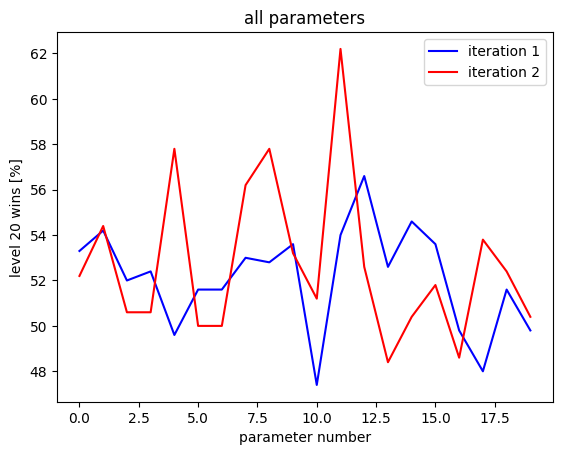

In [194]:
resgrad7=np.load("gradient_step1_v7.npy")
resgrad8=np.load("gradient_step1_v8.npy")
print(np.mean(resgrad7[40,:,:],0))
print(np.mean(resgrad8[40,:,:],0))
plt.plot(range(20),np.mean(resgrad7[40,:,:],1),color='blue',label='iteration 1') 
plt.plot(range(20),np.mean(resgrad8[40,:,:],1),color='red',label='iteration 2') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number")
plt.ylabel("level 20 wins [%]")
plt.title("all parameters")

Again getteing the next parameters and steps. 

In [212]:
new_par2,new_step2=get_new_parameters(resgrad8)
print("difference between new and old parameters")
print(new_par2-new_par1)
print("factor between old and new steps")
print(new_step2/new_step1)

difference between new and old parameters
[0.         0.         0.         0.00113548 0.         0.
 0.         0.01286886 0.         0.         0.01015209 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
factor between old and new steps
[ 3.          3.          3.         -2.67857143  3.          3.
  3.         -2.67857143  3.          3.         -1.5         3.
  3.          3.          3.          3.          3.          3.
  3.        ]


Now I build the function which does that iteratively. 

In [207]:
#parameters,list of open paremeters, discard parameters, value parameters for level 20
# open base, discard base, value base parameters for level 21
# open steps, discard steps, value steps parameters for level 21
def gradient_fit(open_vars,discard_vars,value_vars,base_open,base_discard,base_value,open_step,discard_step,value_step,n_games=100,max_iter=10,output_name="gradient_fit1_it"):
    #to save parameters and steps 
    results=np.zeros((19,max_iter,2))
    for i in range(max_iter):
        print(f"doing iteration {i}")
        start_time=time.time()
        resgrad1=gradient_step1(open_vars,discard_vars,value_vars,base_open,base_discard,base_value,open_step,discard_step,value_step,n_games=n_games)
        np.save(output_name+str(i)+".npy",resgrad1)
        stop_time=time.time()
        print(f"{n_games} games need {np.round(stop_time-start_time,3)} seconds")
        #getting new steps and parameters
        new_par1,new_step1=get_new_parameters(resgrad1)
        results[:,i,0]=new_par1
        results[:,i,1]=new_step1        
        #passing as new base
        base_open=new_par1[0:6]
        base_discard=new_par1[6:12]
        base_value=new_par1[12:19]        
        #passing as new steps
        open_step=new_step1[0:6]
        discard_step=new_step2[6:12]
        value_step=new_step2[12:19]
    return results    

In [222]:
allres2=np.load("mc_v9_all.npy")
c=0
list_open7=[]
list_discard7=[]
list_value7=[]
for i in range(850):
    if np.mean(allres2[40,i,4:6])<45 and np.max(allres2[40,i,:])<60:
        list_open7.append(allres2[19:25,i,0])
        list_discard7.append(allres2[25:31,i,0])        
        list_value7.append(allres2[31:38,i,0]) 
        c+=1
list_open8=list_open7[0:5]
list_discard8=list_discard7[0:5]
list_value8=list_value7[0:5]   
start_time=time.time()
gradient_it1=gradient_fit(list_open8,list_discard8,list_value8,new_par2[0:6],new_par2[6:12],new_par2[12:19],new_step2[0:6],new_step2[6:12],new_step2[12:19],n_games=100,max_iter=16,output_name="gradient_fit1_it")
stop_time=time.time()
print(f"Needed {np.round(stop_time-start_time,3)} seconds")
#105.524 seconds for 2 games and 2 iterations
#100 games 16 iterations Needed 41128.531 seconds
#before fit was started was  53.3, 52.2
#mean of iterations are, 46.5 47.55, 46.6, 63.05, 51.1, 52.6, 41.8, 45.7 seems to 
#have some problems could be overshooting with too large steps how easy solve that
#will produce 20*16=320 data points
#paarmeters seems to get larger at least open intercept, check also others 

doing iteration 0
doing Base model
doing case 0 for level 20
400 games need 95.872 seconds
level 20 won to 47.0 %
doing case 1 for level 20
400 games need 93.902 seconds
level 20 won to 44.5 %
doing case 2 for level 20
400 games need 90.249 seconds
level 20 won to 45.0 %
doing case 3 for level 20
400 games need 93.982 seconds
level 20 won to 47.2 %
doing case 4 for level 20
400 games need 97.303 seconds
level 20 won to 48.8 %
level 20 won in average to 46.5 %
changing open variable 0
doing case 0 for level 20
100 games need 24.698 seconds
level 20 won to 39.0 %
doing case 1 for level 20
100 games need 22.24 seconds
level 20 won to 45.0 %
doing case 2 for level 20
100 games need 22.009 seconds
level 20 won to 50.0 %
doing case 3 for level 20
100 games need 23.917 seconds
level 20 won to 48.0 %
doing case 4 for level 20
100 games need 24.187 seconds
level 20 won to 44.0 %
level 20 won in average to 45.2 %
changing open variable 1
doing case 0 for level 20
100 games need 23.863 seconds
le

100 games need 23.612 seconds
level 20 won to 49.0 %
doing case 1 for level 20
100 games need 22.036 seconds
level 20 won to 48.0 %
doing case 2 for level 20
100 games need 22.268 seconds
level 20 won to 47.0 %
doing case 3 for level 20
100 games need 23.022 seconds
level 20 won to 47.0 %
doing case 4 for level 20
100 games need 23.077 seconds
level 20 won to 52.0 %
level 20 won in average to 48.6 %
changing value variable 6
doing case 0 for level 20
100 games need 23.371 seconds
level 20 won to 44.0 %
doing case 1 for level 20
100 games need 22.503 seconds
level 20 won to 36.0 %
doing case 2 for level 20
100 games need 21.878 seconds
level 20 won to 51.0 %
doing case 3 for level 20
100 games need 23.129 seconds
level 20 won to 47.0 %
doing case 4 for level 20
100 games need 23.412 seconds
level 20 won to 49.0 %
level 20 won in average to 45.4 %
all models done
100 games need 2634.022 seconds
doing iteration 1
doing Base model
doing case 0 for level 20
400 games need 74.241 seconds
lev

100 games need 19.83 seconds
level 20 won to 45.0 %
doing case 1 for level 20
100 games need 17.936 seconds
level 20 won to 40.0 %
doing case 2 for level 20
100 games need 18.707 seconds
level 20 won to 56.0 %
doing case 3 for level 20
100 games need 18.122 seconds
level 20 won to 51.0 %
doing case 4 for level 20
100 games need 16.771 seconds
level 20 won to 44.0 %
level 20 won in average to 47.2 %
changing value variable 4
doing case 0 for level 20
100 games need 18.063 seconds
level 20 won to 62.0 %
doing case 1 for level 20
100 games need 16.904 seconds
level 20 won to 43.0 %
doing case 2 for level 20
100 games need 17.844 seconds
level 20 won to 48.0 %
doing case 3 for level 20
100 games need 17.598 seconds
level 20 won to 51.0 %
doing case 4 for level 20
100 games need 16.786 seconds
level 20 won to 42.0 %
level 20 won in average to 49.2 %
changing value variable 5
doing case 0 for level 20
100 games need 19.41 seconds
level 20 won to 55.0 %
doing case 1 for level 20
100 games nee

100 games need 24.237 seconds
level 20 won to 44.0 %
doing case 1 for level 20
100 games need 21.096 seconds
level 20 won to 45.0 %
doing case 2 for level 20
100 games need 20.928 seconds
level 20 won to 53.0 %
doing case 3 for level 20
100 games need 23.062 seconds
level 20 won to 43.0 %
doing case 4 for level 20
100 games need 24.116 seconds
level 20 won to 45.0 %
level 20 won in average to 46.0 %
changing value variable 2
doing case 0 for level 20
100 games need 23.663 seconds
level 20 won to 52.0 %
doing case 1 for level 20
100 games need 22.291 seconds
level 20 won to 38.0 %
doing case 2 for level 20
100 games need 21.685 seconds
level 20 won to 49.0 %
doing case 3 for level 20
100 games need 22.09 seconds
level 20 won to 47.0 %
doing case 4 for level 20
100 games need 23.899 seconds
level 20 won to 56.0 %
level 20 won in average to 48.4 %
changing value variable 3
doing case 0 for level 20
100 games need 25.072 seconds
level 20 won to 46.0 %
doing case 1 for level 20
100 games ne

100 games need 27.752 seconds
level 20 won to 59.0 %
doing case 1 for level 20
100 games need 23.841 seconds
level 20 won to 65.0 %
doing case 2 for level 20
100 games need 22.469 seconds
level 20 won to 65.0 %
doing case 3 for level 20
100 games need 26.721 seconds
level 20 won to 64.0 %
doing case 4 for level 20
100 games need 27.168 seconds
level 20 won to 67.0 %
level 20 won in average to 64.0 %
changing value variable 0
doing case 0 for level 20
100 games need 27.203 seconds
level 20 won to 58.0 %
doing case 1 for level 20
100 games need 24.356 seconds
level 20 won to 60.0 %
doing case 2 for level 20
100 games need 23.099 seconds
level 20 won to 64.0 %
doing case 3 for level 20
100 games need 27.167 seconds
level 20 won to 64.0 %
doing case 4 for level 20
100 games need 28.929 seconds
level 20 won to 67.0 %
level 20 won in average to 62.6 %
changing value variable 1
doing case 0 for level 20
100 games need 27.562 seconds
level 20 won to 58.0 %
doing case 1 for level 20
100 games n

100 games need 18.776 seconds
level 20 won to 48.0 %
doing case 1 for level 20
100 games need 17.227 seconds
level 20 won to 47.0 %
doing case 2 for level 20
100 games need 18.177 seconds
level 20 won to 43.0 %
doing case 3 for level 20
100 games need 16.764 seconds
level 20 won to 50.0 %
doing case 4 for level 20
100 games need 15.917 seconds
level 20 won to 46.0 %
level 20 won in average to 46.8 %
changing discard variable 4
doing case 0 for level 20
100 games need 19.2 seconds
level 20 won to 65.0 %
doing case 1 for level 20
100 games need 19.088 seconds
level 20 won to 49.0 %
doing case 2 for level 20
100 games need 19.676 seconds
level 20 won to 54.0 %
doing case 3 for level 20
100 games need 18.525 seconds
level 20 won to 58.0 %
doing case 4 for level 20
100 games need 15.698 seconds
level 20 won to 40.0 %
level 20 won in average to 53.2 %
changing discard variable 5
doing case 0 for level 20
100 games need 21.008 seconds
level 20 won to 52.0 %
doing case 1 for level 20
100 games

100 games need 20.072 seconds
level 20 won to 55.0 %
doing case 1 for level 20
100 games need 19.896 seconds
level 20 won to 60.0 %
doing case 2 for level 20
100 games need 21.345 seconds
level 20 won to 62.0 %
doing case 3 for level 20
100 games need 18.555 seconds
level 20 won to 52.0 %
doing case 4 for level 20
100 games need 18.023 seconds
level 20 won to 33.0 %
level 20 won in average to 52.4 %
changing discard variable 2
doing case 0 for level 20
100 games need 28.095 seconds
level 20 won to 53.0 %
doing case 1 for level 20
100 games need 26.796 seconds
level 20 won to 56.0 %
doing case 2 for level 20
100 games need 25.253 seconds
level 20 won to 60.0 %
doing case 3 for level 20
100 games need 24.95 seconds
level 20 won to 46.0 %
doing case 4 for level 20
100 games need 26.809 seconds
level 20 won to 50.0 %
level 20 won in average to 53.0 %
changing discard variable 3
doing case 0 for level 20
100 games need 25.024 seconds
level 20 won to 51.0 %
doing case 1 for level 20
100 game

100 games need 26.841 seconds
level 20 won to 40.0 %
doing case 1 for level 20
100 games need 22.805 seconds
level 20 won to 44.0 %
doing case 2 for level 20
100 games need 23.548 seconds
level 20 won to 50.0 %
doing case 3 for level 20
100 games need 25.347 seconds
level 20 won to 51.0 %
doing case 4 for level 20
100 games need 24.704 seconds
level 20 won to 36.0 %
level 20 won in average to 44.2 %
changing discard variable 0
doing case 0 for level 20
100 games need 27.599 seconds
level 20 won to 45.0 %
doing case 1 for level 20
100 games need 24.401 seconds
level 20 won to 39.0 %
doing case 2 for level 20
100 games need 23.26 seconds
level 20 won to 47.0 %
doing case 3 for level 20
100 games need 25.839 seconds
level 20 won to 43.0 %
doing case 4 for level 20
100 games need 29.176 seconds
level 20 won to 42.0 %
level 20 won in average to 43.2 %
changing discard variable 1
doing case 0 for level 20
100 games need 19.73 seconds
level 20 won to 48.0 %
doing case 1 for level 20
100 games

100 games need 25.562 seconds
level 20 won to 47.0 %
doing case 1 for level 20
100 games need 21.178 seconds
level 20 won to 41.0 %
doing case 2 for level 20
100 games need 20.933 seconds
level 20 won to 47.0 %
doing case 3 for level 20
100 games need 23.017 seconds
level 20 won to 50.0 %
doing case 4 for level 20
100 games need 22.745 seconds
level 20 won to 40.0 %
level 20 won in average to 45.0 %
changing open variable 4
doing case 0 for level 20


/home/tobias/ml-testing/games/skyjo/skyjo_functions4.py:2090: RuntimeWarning: overflow encountered in exp
  res=1/(1+np.exp(-coefs[0]-np.matmul(coefs[1:coefs.shape[0]],data)))


100 games need 25.33 seconds
level 20 won to 59.0 %
doing case 1 for level 20
100 games need 24.114 seconds
level 20 won to 49.0 %
doing case 2 for level 20
100 games need 23.33 seconds
level 20 won to 54.0 %
doing case 3 for level 20
100 games need 24.05 seconds
level 20 won to 46.0 %
doing case 4 for level 20
100 games need 22.307 seconds
level 20 won to 35.0 %
level 20 won in average to 48.6 %
changing open variable 5
doing case 0 for level 20
100 games need 25.291 seconds
level 20 won to 45.0 %
doing case 1 for level 20
100 games need 24.094 seconds
level 20 won to 47.0 %
doing case 2 for level 20
100 games need 22.395 seconds
level 20 won to 43.0 %
doing case 3 for level 20
100 games need 23.716 seconds
level 20 won to 54.0 %
doing case 4 for level 20
100 games need 23.312 seconds
level 20 won to 38.0 %
level 20 won in average to 45.4 %
changing discard variable 0
doing case 0 for level 20
100 games need 27.01 seconds
level 20 won to 39.0 %
doing case 1 for level 20
100 games need

100 games need 22.618 seconds
level 20 won to 49.0 %
doing case 1 for level 20
100 games need 22.185 seconds
level 20 won to 42.0 %
doing case 2 for level 20
100 games need 21.27 seconds
level 20 won to 46.0 %
doing case 3 for level 20
100 games need 21.927 seconds
level 20 won to 46.0 %
doing case 4 for level 20
100 games need 20.762 seconds
level 20 won to 41.0 %
level 20 won in average to 44.8 %
changing open variable 3
doing case 0 for level 20
100 games need 23.922 seconds
level 20 won to 56.0 %
doing case 1 for level 20
100 games need 21.289 seconds
level 20 won to 34.0 %
doing case 2 for level 20
100 games need 21.536 seconds
level 20 won to 52.0 %
doing case 3 for level 20
100 games need 22.279 seconds
level 20 won to 46.0 %
doing case 4 for level 20
100 games need 20.125 seconds
level 20 won to 42.0 %
level 20 won in average to 46.0 %
changing open variable 4
doing case 0 for level 20
100 games need 23.95 seconds
level 20 won to 47.0 %
doing case 1 for level 20
100 games need 

100 games need 22.787 seconds
level 20 won to 49.0 %
doing case 1 for level 20
100 games need 21.747 seconds
level 20 won to 51.0 %
doing case 2 for level 20
100 games need 20.845 seconds
level 20 won to 46.0 %
doing case 3 for level 20
100 games need 22.437 seconds
level 20 won to 50.0 %
doing case 4 for level 20
100 games need 22.421 seconds
level 20 won to 37.0 %
level 20 won in average to 46.6 %
changing open variable 1
doing case 0 for level 20
100 games need 24.105 seconds
level 20 won to 41.0 %
doing case 1 for level 20
100 games need 20.843 seconds
level 20 won to 38.0 %
doing case 2 for level 20
100 games need 21.059 seconds
level 20 won to 44.0 %
doing case 3 for level 20
100 games need 21.874 seconds
level 20 won to 49.0 %
doing case 4 for level 20
100 games need 20.024 seconds
level 20 won to 45.0 %
level 20 won in average to 43.4 %
changing open variable 2
doing case 0 for level 20
100 games need 22.786 seconds
level 20 won to 48.0 %
doing case 1 for level 20
100 games nee

100 games need 22.169 seconds
level 20 won to 51.0 %
doing case 2 for level 20
100 games need 21.199 seconds
level 20 won to 44.0 %
doing case 3 for level 20
100 games need 21.925 seconds
level 20 won to 47.0 %
doing case 4 for level 20
100 games need 21.556 seconds
level 20 won to 41.0 %
level 20 won in average to 46.2 %
all models done
100 games need 2508.707 seconds
doing iteration 10
doing Base model
doing case 0 for level 20
400 games need 95.564 seconds
level 20 won to 44.5 %
doing case 1 for level 20
400 games need 87.643 seconds
level 20 won to 43.8 %
doing case 2 for level 20
400 games need 82.999 seconds
level 20 won to 46.5 %
doing case 3 for level 20
400 games need 87.873 seconds
level 20 won to 53.0 %
doing case 4 for level 20
400 games need 82.994 seconds
level 20 won to 38.2 %
level 20 won in average to 45.2 %
changing open variable 0
doing case 0 for level 20
100 games need 23.255 seconds
level 20 won to 49.0 %
doing case 1 for level 20
100 games need 22.058 seconds
lev

100 games need 21.615 seconds
level 20 won to 41.0 %
doing case 2 for level 20
100 games need 22.298 seconds
level 20 won to 49.0 %
doing case 3 for level 20
100 games need 21.904 seconds
level 20 won to 49.0 %
doing case 4 for level 20
100 games need 20.541 seconds
level 20 won to 43.0 %
level 20 won in average to 44.4 %
changing value variable 5
doing case 0 for level 20
100 games need 23.303 seconds
level 20 won to 46.0 %
doing case 1 for level 20
100 games need 21.484 seconds
level 20 won to 46.0 %
doing case 2 for level 20
100 games need 20.402 seconds
level 20 won to 50.0 %
doing case 3 for level 20
100 games need 22.405 seconds
level 20 won to 40.0 %
doing case 4 for level 20
100 games need 20.731 seconds
level 20 won to 45.0 %
level 20 won in average to 45.4 %
changing value variable 6
doing case 0 for level 20
100 games need 25.36 seconds
level 20 won to 47.0 %
doing case 1 for level 20
100 games need 22.198 seconds
level 20 won to 40.0 %
doing case 2 for level 20
100 games ne

100 games need 21.436 seconds
level 20 won to 48.0 %
doing case 2 for level 20
100 games need 21.252 seconds
level 20 won to 53.0 %
doing case 3 for level 20
100 games need 23.266 seconds
level 20 won to 57.0 %
doing case 4 for level 20
100 games need 21.415 seconds
level 20 won to 31.0 %
level 20 won in average to 46.4 %
changing value variable 3
doing case 0 for level 20
100 games need 23.298 seconds
level 20 won to 58.0 %
doing case 1 for level 20
100 games need 21.844 seconds
level 20 won to 49.0 %
doing case 2 for level 20
100 games need 21.467 seconds
level 20 won to 56.0 %
doing case 3 for level 20
100 games need 22.83 seconds
level 20 won to 39.0 %
doing case 4 for level 20
100 games need 20.052 seconds
level 20 won to 30.0 %
level 20 won in average to 46.4 %
changing value variable 4
doing case 0 for level 20
100 games need 23.365 seconds
level 20 won to 56.0 %
doing case 1 for level 20
100 games need 21.573 seconds
level 20 won to 48.0 %
doing case 2 for level 20
100 games ne

100 games need 23.329 seconds
level 20 won to 45.0 %
doing case 2 for level 20
100 games need 22.362 seconds
level 20 won to 58.0 %
doing case 3 for level 20
100 games need 23.07 seconds
level 20 won to 41.0 %
doing case 4 for level 20
100 games need 22.603 seconds
level 20 won to 34.0 %
level 20 won in average to 45.8 %
changing value variable 1
doing case 0 for level 20
100 games need 24.598 seconds
level 20 won to 46.0 %
doing case 1 for level 20
100 games need 22.684 seconds
level 20 won to 45.0 %
doing case 2 for level 20
100 games need 21.212 seconds
level 20 won to 49.0 %
doing case 3 for level 20
100 games need 23.74 seconds
level 20 won to 54.0 %
doing case 4 for level 20
100 games need 23.783 seconds
level 20 won to 33.0 %
level 20 won in average to 45.4 %
changing value variable 2
doing case 0 for level 20
100 games need 24.501 seconds
level 20 won to 45.0 %
doing case 1 for level 20
100 games need 22.607 seconds
level 20 won to 38.0 %
doing case 2 for level 20
100 games nee

100 games need 22.14 seconds
level 20 won to 37.0 %
doing case 2 for level 20
100 games need 20.478 seconds
level 20 won to 51.0 %
doing case 3 for level 20
100 games need 21.618 seconds
level 20 won to 46.0 %
doing case 4 for level 20
100 games need 20.217 seconds
level 20 won to 37.0 %
level 20 won in average to 43.0 %
changing discard variable 5
doing case 0 for level 20
100 games need 25.891 seconds
level 20 won to 45.0 %
doing case 1 for level 20
100 games need 23.143 seconds
level 20 won to 35.0 %
doing case 2 for level 20
100 games need 22.307 seconds
level 20 won to 41.0 %
doing case 3 for level 20
100 games need 23.931 seconds
level 20 won to 46.0 %
doing case 4 for level 20
100 games need 24.53 seconds
level 20 won to 45.0 %
level 20 won in average to 42.4 %
changing value variable 0
doing case 0 for level 20
100 games need 25.342 seconds
level 20 won to 47.0 %
doing case 1 for level 20
100 games need 22.438 seconds
level 20 won to 46.0 %
doing case 2 for level 20
100 games n

100 games need 22.143 seconds
level 20 won to 47.0 %
doing case 2 for level 20
100 games need 23.394 seconds
level 20 won to 51.0 %
doing case 3 for level 20
100 games need 25.961 seconds
level 20 won to 49.0 %
doing case 4 for level 20
100 games need 25.737 seconds
level 20 won to 37.0 %
level 20 won in average to 45.8 %
changing discard variable 3
doing case 0 for level 20
100 games need 25.096 seconds
level 20 won to 48.0 %
doing case 1 for level 20
100 games need 23.09 seconds
level 20 won to 48.0 %
doing case 2 for level 20
100 games need 21.599 seconds
level 20 won to 45.0 %
doing case 3 for level 20
100 games need 21.853 seconds
level 20 won to 50.0 %
doing case 4 for level 20
100 games need 20.811 seconds
level 20 won to 37.0 %
level 20 won in average to 45.6 %
changing discard variable 4
doing case 0 for level 20
100 games need 24.06 seconds
level 20 won to 47.0 %
doing case 1 for level 20
100 games need 21.418 seconds
level 20 won to 42.0 %
doing case 2 for level 20
100 games

100 games need 24.033 seconds
level 20 won to 51.0 %
doing case 2 for level 20
100 games need 22.488 seconds
level 20 won to 56.0 %
doing case 3 for level 20
100 games need 25.657 seconds
level 20 won to 36.0 %
doing case 4 for level 20
100 games need 25.816 seconds
level 20 won to 38.0 %
level 20 won in average to 45.0 %
changing discard variable 1
doing case 0 for level 20
100 games need 19.54 seconds
level 20 won to 45.0 %
doing case 1 for level 20
100 games need 18.976 seconds
level 20 won to 46.0 %
doing case 2 for level 20
100 games need 19.953 seconds
level 20 won to 64.0 %
doing case 3 for level 20
100 games need 17.475 seconds
level 20 won to 56.0 %
doing case 4 for level 20
100 games need 16.565 seconds
level 20 won to 40.0 %
level 20 won in average to 50.2 %
changing discard variable 2
doing case 0 for level 20
100 games need 26.016 seconds
level 20 won to 52.0 %
doing case 1 for level 20
100 games need 23.313 seconds
level 20 won to 42.0 %
doing case 2 for level 20
100 game

Now I get the results and plot them. 

Text(0.5, 1.0, 'gradient fit 1')

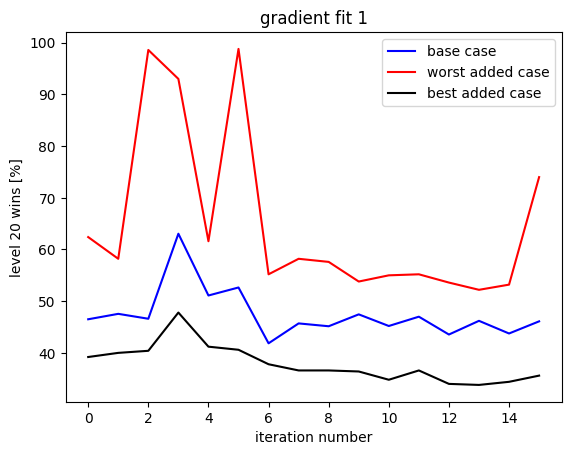

In [238]:
gradfit0=np.load('gradient_fit1_it0.npy')
gradfit1=np.load('gradient_fit1_it1.npy')
gradfit2=np.load('gradient_fit1_it2.npy')
gradfit3=np.load('gradient_fit1_it3.npy')
gradfit4=np.load('gradient_fit1_it4.npy')
gradfit5=np.load('gradient_fit1_it5.npy')
gradfit6=np.load('gradient_fit1_it6.npy')
gradfit7=np.load('gradient_fit1_it7.npy')
gradfit8=np.load('gradient_fit1_it8.npy')
gradfit9=np.load('gradient_fit1_it9.npy')
gradfit10=np.load('gradient_fit1_it10.npy')
gradfit11=np.load('gradient_fit1_it11.npy')
gradfit12=np.load('gradient_fit1_it12.npy')
gradfit13=np.load('gradient_fit1_it13.npy')
gradfit14=np.load('gradient_fit1_it14.npy')
gradfit15=np.load('gradient_fit1_it15.npy')
#np.save('gradient_fit1.npy',gradient_it1)
allpargrad1=np.load('gradient_fit1.npy')
listgrad=[gradfit0,gradfit1,gradfit2,gradfit3,gradfit4,gradfit5,gradfit6,gradfit7,gradfit8,gradfit9,gradfit10,gradfit11,gradfit12,gradfit13,gradfit14,gradfit15]
allgrad1=np.zeros((gradfit15.shape[0],gradfit15.shape[1],gradfit15.shape[2],len(listgrad)))
for i in range(len(listgrad)):
    allgrad1[:,:,:,i]=listgrad[i]
plt.plot(range(16),np.mean(allgrad1[40,0,:,:],0),color='blue',label='base case') 
plt.plot(range(16),np.mean(np.max(allgrad1[40,1:20,:,:],0),0),color='red',label='worst added case') 
plt.plot(range(16),np.mean(np.min(allgrad1[40,1:20,:,:],0),0),color='black',label='best added case') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("iteration number")
plt.ylabel("level 20 wins [%]")
plt.title("gradient fit 1")    

The worst exlored case can be up to 100%, but that is not necessary a problem. However, it makes it difficult to see improvement, thus I now just plot base case and best case. 

Text(0.5, 1.0, 'gradient fit 1')

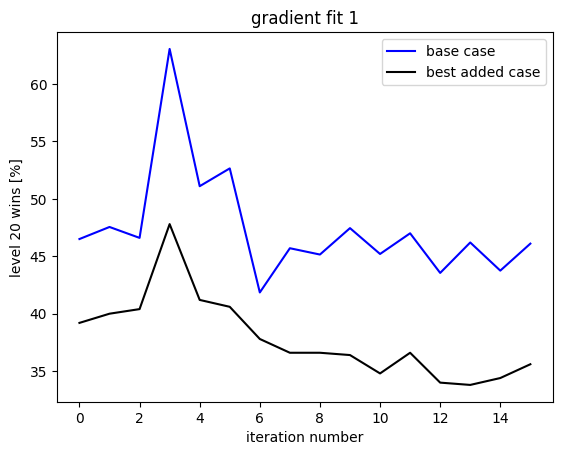

In [239]:
plt.plot(range(16),np.mean(allgrad1[40,0,:,:],0),color='blue',label='base case') 
plt.plot(range(16),np.mean(np.min(allgrad1[40,1:20,:,:],0),0),color='black',label='best added case') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("iteration number")
plt.ylabel("level 20 wins [%]")
plt.title("gradient fit 1")    

The improvement in the case case is very minor overall, the best explored is better. In the best case there is more improvement, but 66% win of a new model is still not really good. There must some problem in the getting good parameters. It seems to work sometimes, but not always.  

Now looking on all cases.

98.6
98.8


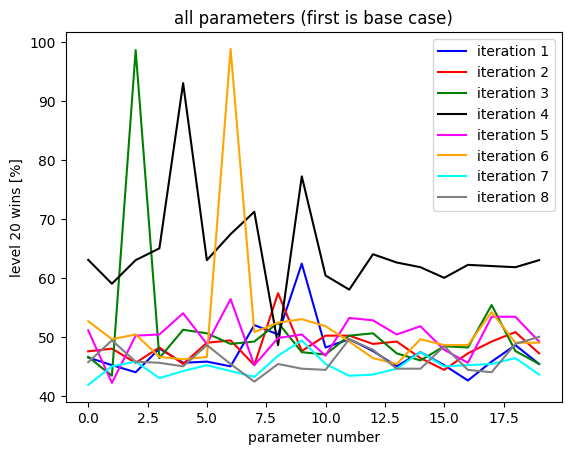

In [267]:
plt.plot(range(20),np.mean(allgrad1[40,:,:,0],1),color='blue',label='iteration 1') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,1],1),color='red',label='iteration 2') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,2],1),color='green',label='iteration 3') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,3],1),color='black',label='iteration 4') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,4],1),color='magenta',label='iteration 5') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,5],1),color='orange',label='iteration 6') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,6],1),color='cyan',label='iteration 7') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,7],1),color='gray',label='iteration 8') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number (0 is base case)")
plt.ylabel("level 20 wins [%]")
#plt.title("all parameters (first is base case)")
print(max(np.mean(allgrad1[40,:,:,2],1)))
print(max(np.mean(allgrad1[40,:,:,5],1)))

98.6
98.8


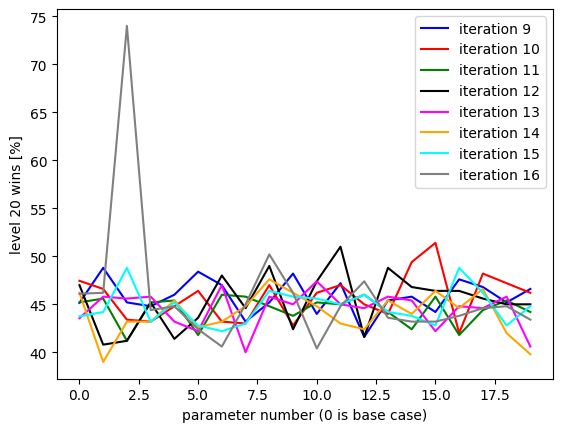

In [268]:
plt.plot(range(20),np.mean(allgrad1[40,:,:,8],1),color='blue',label='iteration 9') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,9],1),color='red',label='iteration 10') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,10],1),color='green',label='iteration 11') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,11],1),color='black',label='iteration 12') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,12],1),color='magenta',label='iteration 13') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,13],1),color='orange',label='iteration 14') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,14],1),color='cyan',label='iteration 15') 
plt.plot(range(20),np.mean(allgrad1[40,:,:,15],1),color='gray',label='iteration 16') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number (0 is base case)")
plt.ylabel("level 20 wins [%]")
#plt.title("all parameters (first is base case)")
print(max(np.mean(allgrad1[40,:,:,2],1)))
print(max(np.mean(allgrad1[40,:,:,5],1)))

Clearly worse fit appears after very win fraction of 98.6%. But another case of 98.8 does not have a notable worsening. 
Besides that it mostly seems a random walk with no clear cases of improvement for a certain changed parameter. Like too little parameters changes. Now I am looking on the parameters explored. 


Text(0.5, 1.0, 'open parameters')

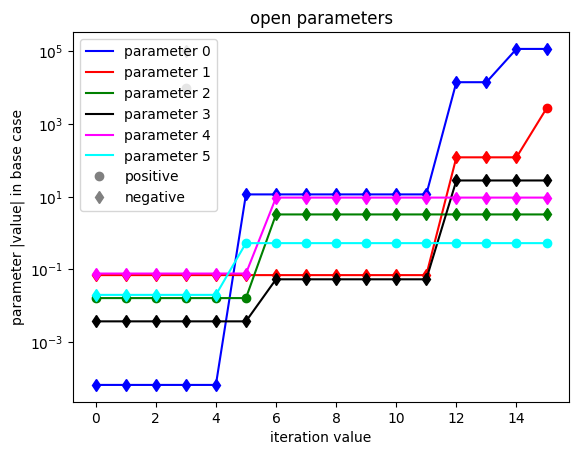

In [298]:
plt.plot(range(16),(allgrad1[19,0,0,:]*np.sign(allgrad1[19,0,0,:])),color='blue',label='parameter 0') 
plt.plot(range(16),allgrad1[19,0,0,:],'o',color='blue') 
plt.plot(range(16),-allgrad1[19,0,0,:],'d',color='blue') 
plt.plot(range(16),(allgrad1[20,0,0,:]*np.sign(allgrad1[20,0,0,:])),color='red',label='parameter 1') 
plt.plot(range(16),allgrad1[20,0,0,:],'o',color='red') 
plt.plot(range(16),-allgrad1[20,0,0,:],'d',color='red') 
plt.plot(range(16),(allgrad1[21,0,0,:]*np.sign(allgrad1[21,0,0,:])),color='green',label='parameter 2') 
plt.plot(range(16),allgrad1[21,0,0,:],'o',color='green') 
plt.plot(range(16),-allgrad1[21,0,0,:],'d',color='green') 
plt.plot(range(16),(allgrad1[22,0,0,:]*np.sign(allgrad1[22,0,0,:])),color='black',label='parameter 3') 
plt.plot(range(16),allgrad1[22,0,0,:],'o',color='black') 
plt.plot(range(16),-allgrad1[22,0,0,:],'d',color='black') 
plt.plot(range(16),(allgrad1[23,0,0,:]*np.sign(allgrad1[23,0,0,:])),color='magenta',label='parameter 4') 
plt.plot(range(16),allgrad1[23,0,0,:],'o',color='magenta') 
plt.plot(range(16),-allgrad1[23,0,0,:],'d',color='magenta') 
plt.plot(range(16),(allgrad1[24,0,0,:]*np.sign(allgrad1[24,0,0,:])),color='cyan',label='parameter 5') 
plt.plot(range(16),allgrad1[24,0,0,:],'o',color='cyan') 
plt.plot(range(16),-allgrad1[24,0,0,:],'d',color='cyan') 
plt.plot(3,10000,'o',color='gray',label='positive') 
plt.plot(3,100000,'d',color='gray',label='negative') 
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("iteration value")
plt.ylabel("parameter |value| in base case")
plt.title("open parameters")

Text(0.5, 1.0, 'discard parameters')

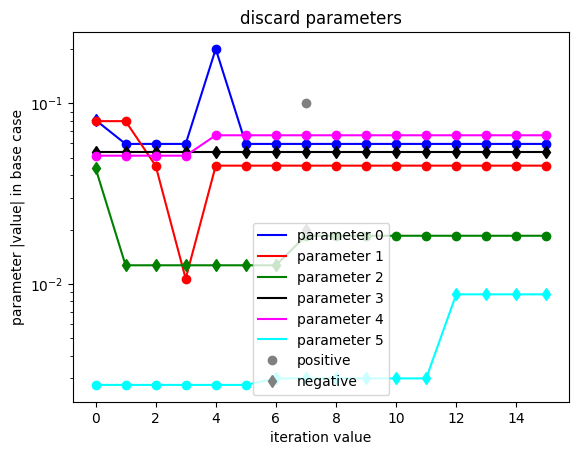

In [302]:
plt.plot(range(16),(allgrad1[25,0,0,:]*np.sign(allgrad1[25,0,0,:])),color='blue',label='parameter 0') 
plt.plot(range(16),allgrad1[25,0,0,:],'o',color='blue') 
plt.plot(range(16),-allgrad1[25,0,0,:],'d',color='blue') 
plt.plot(range(16),(allgrad1[26,0,0,:]*np.sign(allgrad1[26,0,0,:])),color='red',label='parameter 1') 
plt.plot(range(16),allgrad1[26,0,0,:],'o',color='red') 
plt.plot(range(16),-allgrad1[26,0,0,:],'d',color='red') 
plt.plot(range(16),(allgrad1[27,0,0,:]*np.sign(allgrad1[27,0,0,:])),color='green',label='parameter 2') 
plt.plot(range(16),allgrad1[27,0,0,:],'o',color='green') 
plt.plot(range(16),-allgrad1[27,0,0,:],'d',color='green') 
plt.plot(range(16),(allgrad1[28,0,0,:]*np.sign(allgrad1[28,0,0,:])),color='black',label='parameter 3') 
plt.plot(range(16),allgrad1[28,0,0,:],'o',color='black') 
plt.plot(range(16),-allgrad1[28,0,0,:],'d',color='black') 
plt.plot(range(16),(allgrad1[29,0,0,:]*np.sign(allgrad1[29,0,0,:])),color='magenta',label='parameter 4') 
plt.plot(range(16),allgrad1[29,0,0,:],'o',color='magenta') 
plt.plot(range(16),-allgrad1[29,0,0,:],'d',color='magenta') 
plt.plot(range(16),(allgrad1[30,0,0,:]*np.sign(allgrad1[30,0,0,:])),color='cyan',label='parameter 5') 
plt.plot(range(16),allgrad1[30,0,0,:],'o',color='cyan') 
plt.plot(range(16),-allgrad1[30,0,0,:],'d',color='cyan') 
plt.plot(7,0.1,'o',color='gray',label='positive') 
plt.plot(7,0.02,'d',color='gray',label='negative') 
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("iteration value")
plt.ylabel("parameter |value| in base case")
plt.title("discard parameters")

Text(0.5, 1.0, 'value parameters')

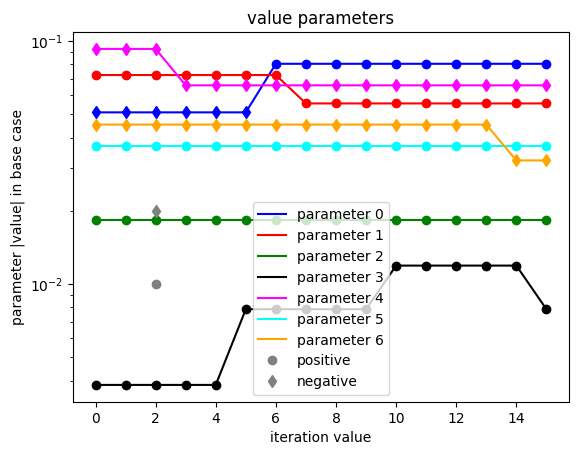

In [305]:
plt.plot(range(16),(allgrad1[31,0,0,:]*np.sign(allgrad1[31,0,0,:])),color='blue',label='parameter 0') 
plt.plot(range(16),allgrad1[31,0,0,:],'o',color='blue') 
plt.plot(range(16),-allgrad1[31,0,0,:],'d',color='blue') 
plt.plot(range(16),(allgrad1[32,0,0,:]*np.sign(allgrad1[32,0,0,:])),color='red',label='parameter 1') 
plt.plot(range(16),allgrad1[32,0,0,:],'o',color='red') 
plt.plot(range(16),-allgrad1[32,0,0,:],'d',color='red') 
plt.plot(range(16),(allgrad1[33,0,0,:]*np.sign(allgrad1[33,0,0,:])),color='green',label='parameter 2') 
plt.plot(range(16),allgrad1[33,0,0,:],'o',color='green') 
plt.plot(range(16),-allgrad1[33,0,0,:],'d',color='green') 
plt.plot(range(16),(allgrad1[34,0,0,:]*np.sign(allgrad1[34,0,0,:])),color='black',label='parameter 3') 
plt.plot(range(16),allgrad1[34,0,0,:],'o',color='black') 
plt.plot(range(16),-allgrad1[34,0,0,:],'d',color='black') 
plt.plot(range(16),(allgrad1[35,0,0,:]*np.sign(allgrad1[35,0,0,:])),color='magenta',label='parameter 4') 
plt.plot(range(16),allgrad1[35,0,0,:],'o',color='magenta') 
plt.plot(range(16),-allgrad1[35,0,0,:],'d',color='magenta') 
plt.plot(range(16),(allgrad1[36,0,0,:]*np.sign(allgrad1[36,0,0,:])),color='cyan',label='parameter 5') 
plt.plot(range(16),allgrad1[36,0,0,:],'o',color='cyan') 
plt.plot(range(16),-allgrad1[36,0,0,:],'d',color='cyan') 
plt.plot(range(16),(allgrad1[37,0,0,:]*np.sign(allgrad1[37,0,0,:])),color='orange',label='parameter 6') 
plt.plot(range(16),allgrad1[37,0,0,:],'o',color='orange') 
plt.plot(range(16),-allgrad1[37,0,0,:],'d',color='orange') 
plt.plot(2,0.01,'o',color='gray',label='positive') 
plt.plot(2,0.02,'d',color='gray',label='negative') 
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("iteration value")
plt.ylabel("parameter |value| in base case")
plt.title("value parameters")

The parameters in the base case only change sometimes. That is the result of doing nothing when detecting a significant change in the good direction. This is still the right action, when that is case, however good changes happen too rarely. It is not because the optimum is reached because the xgboost method finds better case. 

Text(0.5, 1.0, 'open parameters')

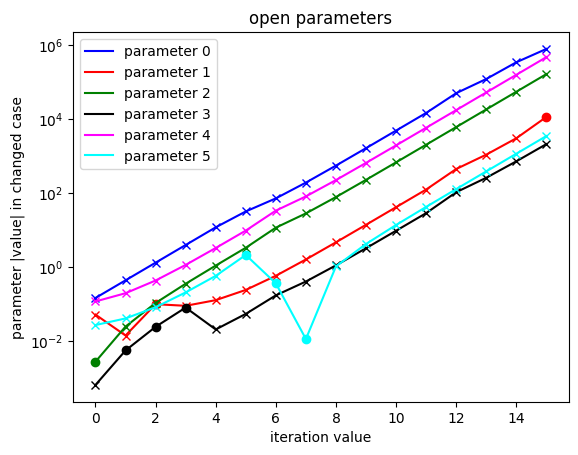

In [306]:
plt.plot(range(16),(allgrad1[19,1,0,:]*np.sign(allgrad1[19,1,0,:])),color='blue',label='parameter 0') 
plt.plot(range(16),allgrad1[19,1,0,:],'o',color='blue') 
plt.plot(range(16),-allgrad1[19,1,0,:],'x',color='blue') 
plt.plot(range(16),(allgrad1[20,2,0,:]*np.sign(allgrad1[20,2,0,:])),color='red',label='parameter 1') 
plt.plot(range(16),allgrad1[20,2,0,:],'o',color='red') 
plt.plot(range(16),-allgrad1[20,2,0,:],'x',color='red') 
plt.plot(range(16),(allgrad1[21,3,0,:]*np.sign(allgrad1[21,3,0,:])),color='green',label='parameter 2') 
plt.plot(range(16),allgrad1[21,3,0,:],'o',color='green') 
plt.plot(range(16),-allgrad1[21,3,0,:],'x',color='green') 
plt.plot(range(16),(allgrad1[22,4,0,:]*np.sign(allgrad1[22,4,0,:])),color='black',label='parameter 3') 
plt.plot(range(16),allgrad1[22,4,0,:],'o',color='black') 
plt.plot(range(16),-allgrad1[22,4,0,:],'x',color='black') 
plt.plot(range(16),(allgrad1[23,5,0,:]*np.sign(allgrad1[23,5,0,:])),color='magenta',label='parameter 4') 
plt.plot(range(16),allgrad1[23,5,0,:],'o',color='magenta') 
plt.plot(range(16),-allgrad1[23,5,0,:],'x',color='magenta') 
plt.plot(range(16),(allgrad1[24,6,0,:]*np.sign(allgrad1[24,6,0,:])),color='cyan',label='parameter 5') 
plt.plot(range(16),allgrad1[24,6,0,:],'o',color='cyan') 
plt.plot(range(16),-allgrad1[24,6,0,:],'x',color='cyan') 
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("iteration value")
plt.ylabel("parameter |value| in changed case")
plt.title("open parameters")

Text(0.5, 1.0, 'discard parameters')

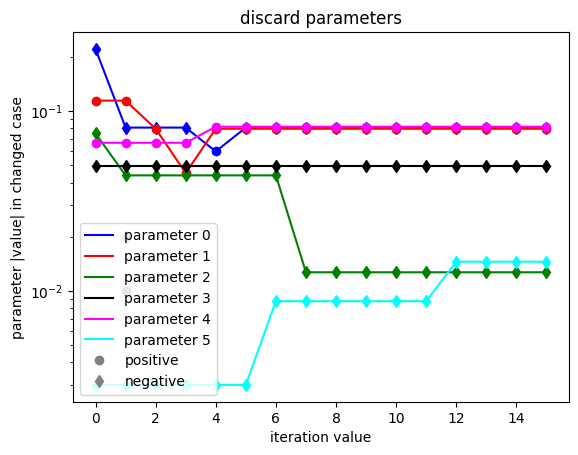

In [309]:
plt.plot(range(16),(allgrad1[25,7,0,:]*np.sign(allgrad1[25,7,0,:])),color='blue',label='parameter 0') 
plt.plot(range(16),allgrad1[25,7,0,:],'o',color='blue') 
plt.plot(range(16),-allgrad1[25,7,0,:],'d',color='blue') 
plt.plot(range(16),(allgrad1[26,8,0,:]*np.sign(allgrad1[26,8,0,:])),color='red',label='parameter 1') 
plt.plot(range(16),allgrad1[26,8,0,:],'o',color='red') 
plt.plot(range(16),-allgrad1[26,8,0,:],'d',color='red') 
plt.plot(range(16),(allgrad1[27,9,0,:]*np.sign(allgrad1[27,9,0,:])),color='green',label='parameter 2') 
plt.plot(range(16),allgrad1[27,9,0,:],'o',color='green') 
plt.plot(range(16),-allgrad1[27,9,0,:],'d',color='green') 
plt.plot(range(16),(allgrad1[28,10,0,:]*np.sign(allgrad1[28,10,0,:])),color='black',label='parameter 3') 
plt.plot(range(16),allgrad1[28,10,0,:],'o',color='black') 
plt.plot(range(16),-allgrad1[28,10,0,:],'d',color='black') 
plt.plot(range(16),(allgrad1[29,11,0,:]*np.sign(allgrad1[29,11,0,:])),color='magenta',label='parameter 4') 
plt.plot(range(16),allgrad1[29,11,0,:],'o',color='magenta') 
plt.plot(range(16),-allgrad1[29,11,0,:],'d',color='magenta') 
plt.plot(range(16),(allgrad1[30,12,0,:]*np.sign(allgrad1[30,12,0,:])),color='cyan',label='parameter 5') 
plt.plot(range(16),allgrad1[30,12,0,:],'o',color='cyan') 
plt.plot(range(16),-allgrad1[30,12,0,:],'d',color='cyan') 
plt.plot(1,0.01,'o',color='gray',label='positive') 
plt.plot(1,0.02,'d',color='gray',label='negative') 
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("iteration value")
plt.ylabel("parameter |value| in changed case")
plt.title("discard parameters")

Text(0.5, 1.0, 'value parameters')

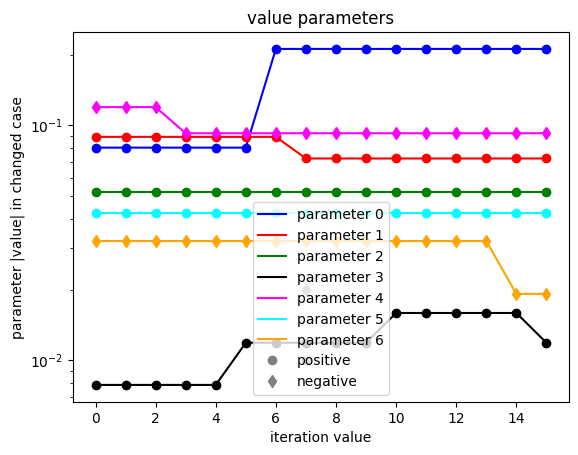

In [311]:
plt.plot(range(16),(allgrad1[31,13,0,:]*np.sign(allgrad1[31,13,0,:])),color='blue',label='parameter 0') 
plt.plot(range(16),allgrad1[31,13,0,:],'o',color='blue') 
plt.plot(range(16),-allgrad1[31,13,0,:],'d',color='blue') 
plt.plot(range(16),(allgrad1[32,14,0,:]*np.sign(allgrad1[32,14,0,:])),color='red',label='parameter 1') 
plt.plot(range(16),allgrad1[32,14,0,:],'o',color='red') 
plt.plot(range(16),-allgrad1[32,14,0,:],'d',color='red') 
plt.plot(range(16),(allgrad1[33,15,0,:]*np.sign(allgrad1[33,15,0,:])),color='green',label='parameter 2') 
plt.plot(range(16),allgrad1[33,15,0,:],'o',color='green') 
plt.plot(range(16),-allgrad1[33,15,0,:],'d',color='green') 
plt.plot(range(16),(allgrad1[34,16,0,:]*np.sign(allgrad1[34,16,0,:])),color='black',label='parameter 3') 
plt.plot(range(16),allgrad1[34,16,0,:],'o',color='black') 
plt.plot(range(16),-allgrad1[34,16,0,:],'d',color='black') 
plt.plot(range(16),(allgrad1[35,17,0,:]*np.sign(allgrad1[35,17,0,:])),color='magenta',label='parameter 4') 
plt.plot(range(16),allgrad1[35,17,0,:],'o',color='magenta') 
plt.plot(range(16),-allgrad1[35,17,0,:],'d',color='magenta') 
plt.plot(range(16),(allgrad1[36,18,0,:]*np.sign(allgrad1[36,18,0,:])),color='cyan',label='parameter 5') 
plt.plot(range(16),allgrad1[36,18,0,:],'o',color='cyan') 
plt.plot(range(16),-allgrad1[36,18,0,:],'d',color='cyan') 
plt.plot(range(16),(allgrad1[37,19,0,:]*np.sign(allgrad1[37,19,0,:])),color='orange',label='parameter 6') 
plt.plot(range(16),allgrad1[37,19,0,:],'o',color='orange') 
plt.plot(range(16),-allgrad1[37,19,0,:],'d',color='orange') 
plt.plot(7,0.01,'o',color='gray',label='positive') 
plt.plot(7,0.02,'d',color='gray',label='negative') 
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("iteration value")
plt.ylabel("parameter |value| in changed case")
plt.title("value parameters")

In the explore parameters there is a little more variation but overall there is also too much of getting larger in case of open. It is rather constant for discard and value, too constant.  

Posssible a problem is that when all are increased by the same factor, all is canceling out. Maybe I should add a random sign determination for the shift when no improevement is detected. Another reason reason could that it is open it is not particulary sensitive to it, that is known. 

It is rather constant for discard and value, too constant. Looks like a coding mistake.  



Below function runs a single potentially new model in level 21 against a collection of level 20 models. 

In [253]:
#running asignle level 21 against a list of level 20 models 
def run_level21(open_vars,discard_vars,value_vars,open_target,discard_target,value_target,n_games):
    #getting the same level 21 model 
    results=np.zeros((41,len(open_vars)))
    level21_open_variable=np.array(open_target)
    level21_discard_variable=np.array(discard_target)      
    level21_value_variable=np.array(value_target)                 
    for k in range(len(open_vars)):
        print(f"doing case {k} for level 20")
        level20_open_variable=np.array(open_vars[k])
        level20_discard_variable=np.array(discard_vars[k])
        level20_value_variable=np.array(value_vars[k])             
        results[0:6,k]=level20_open_variable
        results[6:12,k]=level20_discard_variable
        results[12:19,k]=level20_value_variable    
        results[19:25,k]=level21_open_variable
        results[25:31,k]=level21_discard_variable
        results[31:38,k]=level21_value_variable         
        win20=0
        start_time=time.time()  
        for i in range(n_games):
            names=['alpha','beta']
            nature=['computer','computer']
            levels=[20,21]
            winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
            if winner[0]==1:
                win20+=1                    
            results[38,k]=n_games
            results[39,k]=win20
            results[40,k]=100*win20/n_games     
            stop_time=time.time()
        print(f"{n_games} games need {np.round(stop_time-start_time,3)} seconds")
        print(f"level 20 won to {np.round(results[40,k],1)} %")
    print(f"level 20 won in average to {np.round(np.mean(results[40,:]),1)} %") 
    print("all models done") 
    return results 

I use this model to run the collection of base models used in the several fits against the best of the base models. That give a baseline to compare the performanace against. 


In [254]:
allres2=np.load("mc_v9_all.npy")
c=0
list_open7=[]
list_discard7=[]
list_value7=[]
for i in range(850):
    if np.mean(allres2[40,i,4:6])<45 and np.max(allres2[40,i,:])<60:
        list_open7.append(allres2[19:25,i,0])
        list_discard7.append(allres2[25:31,i,0])        
        list_value7.append(allres2[31:38,i,0]) 
        if np.mean(allres2[40,i,4:6])<29 and np.mean(allres2[40,i,0:6])<23.32:
            print(f"best model {c} has mean loss of {np.mean(allres2[40,i,0:6])}")
        c+=1    

#model is best in put (3 very similar but does not matter much)
target_open=list_open7[5]
target_discard=list_discard7[5]
target_value=list_value7[5]

start_time=time.time()
n_games=1000
allres=run_level21(list_open7,list_discard7,list_value7,target_open,target_discard,target_value,n_games)
np.save("base_model_v1.npy",allres)
stop_time=time.time()
print(f"{n_games} ran for {np.round(stop_time-start_time,2)} seconds")   
#20 games 29.25

best model 5 has mean loss of 23.307692307692307
doing case 0 for level 20
1000 games need 274.241 seconds
level 20 won to 49.0 %
doing case 1 for level 20
1000 games need 299.19 seconds
level 20 won to 47.6 %
doing case 2 for level 20
1000 games need 257.535 seconds
level 20 won to 52.8 %
doing case 3 for level 20
1000 games need 285.457 seconds
level 20 won to 54.3 %
doing case 4 for level 20
1000 games need 297.044 seconds
level 20 won to 55.3 %
doing case 5 for level 20
1000 games need 247.558 seconds
level 20 won to 50.2 %
level 20 won in average to 51.5 %
all models done
1000 ran for 1661.03 seconds


Looking on the results. 

In [257]:
oldbest=np.load('base_model_v1.npy')
print(f"The 5 other models won to {np.round(oldbest[40,0:5],1)} %")
print(f"Against itself it won to {np.round(oldbest[40,5],1)} %")
print(f"In average of all level 20 won to {np.round(np.mean(oldbest[40,0:6]),1)} %")
print(f"Excluding the last level 20 won to {np.round(np.mean(oldbest[40,0:5]),1)} % in average")

The 5 other models won to [49.  47.6 52.8 54.3 55.3] %
Against itself it won to 50.2 %
In average of all level 20 won to 51.5 %
Excluding the last level 20 won to 51.8 % in average


There is variation and now other models are better. That could be because of the larger number of runs or that because when model 2 is better than model 1 it is not necssary also better against model 0 than model 1.  It does not matter so much, more important is that there is no relevant difference of the all model 6 (used with xgboost) and the first 5 (used in gradient). Thus results for those two can be directly compared.  And it is 51.5%

Below I explore another. I use some machine learning method to learn from the features which combinations are better than random ones.
Then I create random numbers and predict the performance for all. I then the select better ones for actual games.

As algorithm I use xgboost because the data set is not large enough that deep leaning makes sense and because the win fraction is limited at 0 and 100% it is not linear. 

First I adapt the function which a regularziation grid to a 2d grid which also includes a maximum depth grid. 

In [106]:
#2 grid in l2regularziation and max depth
#parameters: feature of train, target of train, feature of test, target of test,
#minimum max deoth, maximum max depth, minimum l2 regularization,
#factor of increase, number of steps, output file name regression=True default
#save=True default, result saved as file otherwise returns the results 
def loop_reg2(feature_train, target_train, feature_test, target_test,max_depth_start,max_depth_stop,reg_start,reg_increase,reg_steps,file_name,regression=True,save=True):
    #creates file to be saved 
    resb=np.zeros((4,reg_steps,int(max_depth_stop-max_depth_start+1)))
    #regularization grid
    for i in range(reg_steps):
        print(f"regularization doing case {i}")
        #max depth grid 
        for j in range(resb.shape[2]):
            regularization=reg_start*reg_increase**i
            max_depth=j+max_depth_start
            #regression
            if regression==True:
                ar=do_xgb(feature_train, target_train, feature_test, target_test,max_depth,reg=regularization)
            #classification
            else:
                ar=do_xgb_class(feature_train, target_train, feature_test, target_test,max_depth,reg=regularization)
            resb[:,i,j]=ar
    if save==True:        
        np.save(file_name, resb) 
    else:        
        return resb        

Now I ran, I create several fiels with different random seeds to reduce random noise.

In [146]:
#several random states seed increases from 1 to 6 as filename 
feature_train,feature_test,target_train,target_test=train_test_split(allres3[19:38,:,0].T,np.mean(allres3[40,:,:],1),train_size=0.67, shuffle=True, random_state=6)
loop_reg2(feature_train, target_train, feature_test, target_test,1,11,1,1.414,30,"xgb_grad6.npy")

regularization doing case 0
xgb took 0.0537 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.2909 points
standard deviation of prediction-train 5.598 points
xgb took 0.0603 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.9901 points
standard deviation of prediction-train 3.1665 points
xgb took 0.1028 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.0068 points
standard deviation of prediction-train 1.5888 points
xgb took 0.1181 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.7094 points
standard deviation of prediction-train 0.6338 points
xgb took 0.1575 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard devi

xgb took 0.1621 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.9479 points
standard deviation of prediction-train 0.1758 points
xgb took 0.1317 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.0 points
standard deviation of prediction-train 0.1574 points
xgb took 0.1626 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.81 points
standard deviation of prediction-train 0.1468 points
xgb took 0.1262 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.9704 points
standard deviation of prediction-train 0.135 points
xgb took 0.1426 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.798 po

xgb took 0.1035 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.6222 points
standard deviation of prediction-train 1.6553 points
xgb took 0.1038 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.839 points
standard deviation of prediction-train 0.8479 points
xgb took 0.1271 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.63 points
standard deviation of prediction-train 0.641 points
xgb took 0.1208 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.7005 points
standard deviation of prediction-train 0.598 points
xgb took 0.1179 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.0624 

xgb took 0.1431 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.9644 points
standard deviation of prediction-train 1.1104 points
xgb took 0.1013 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.961 points
standard deviation of prediction-train 1.1161 points
regularization doing case 11
xgb took 0.0388 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.2751 points
standard deviation of prediction-train 5.778 points
xgb took 0.0999 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.9326 points
standard deviation of prediction-train 3.8268 points
xgb took 0.0966 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard devi

xgb took 0.082 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.5976 points
standard deviation of prediction-train 3.5797 points
xgb took 0.0602 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.6984 points
standard deviation of prediction-train 3.3695 points
xgb took 0.0648 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.5459 points
standard deviation of prediction-train 3.0405 points
xgb took 0.0778 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.6346 points
standard deviation of prediction-train 2.8743 points
xgb took 0.0835 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.7

xgb took 0.09 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.0412 points
standard deviation of prediction-train 4.5047 points
xgb took 0.088 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 4.9786 points
standard deviation of prediction-train 4.3798 points
regularization doing case 18
xgb took 0.0423 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.6877 points
standard deviation of prediction-train 6.5081 points
xgb took 0.0482 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.4228 points
standard deviation of prediction-train 6.058 points
xgb took 0.0794 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviat

xgb took 0.0903 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.9499 points
standard deviation of prediction-train 6.6956 points
xgb took 0.066 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.9602 points
standard deviation of prediction-train 6.6849 points
xgb took 0.0658 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.9685 points
standard deviation of prediction-train 6.6819 points
xgb took 0.0972 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.9672 points
standard deviation of prediction-train 6.679 points
xgb took 0.1867 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 5.96

xgb took 0.0753 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 6.2341 points
standard deviation of prediction-train 7.4177 points
xgb took 0.0551 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 6.2336 points
standard deviation of prediction-train 7.4174 points
xgb took 0.0559 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 6.2336 points
standard deviation of prediction-train 7.4174 points
xgb took 0.0925 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 6.2336 points
standard deviation of prediction-train 7.4174 points
xgb took 0.06 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 6.23

xgb took 0.0652 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 6.2125 points
standard deviation of prediction-train 7.4932 points
xgb took 0.0561 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 6.2125 points
standard deviation of prediction-train 7.4932 points
regularization doing case 29
xgb took 0.0417 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 6.2125 points
standard deviation of prediction-train 7.4932 points
xgb took 0.0512 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard deviation of prediction-test 6.2125 points
standard deviation of prediction-train 7.4932 points
xgb took 0.0628 seconds
standard deviation of test 6.2125 points
standard deviation of train 7.4932  points
standard de

Below I load them and average them. First I look on the training set. 

In [147]:
xres1=np.load("xgb_grad1.npy")
xres2=np.load("xgb_grad2.npy")
xres3=np.load("xgb_grad3.npy")
xres4=np.load("xgb_grad4.npy")
xres5=np.load("xgb_grad5.npy")
xres6=np.load("xgb_grad6.npy")
xres=(xres1+xres2+xres3+xres4+xres5+xres6)/6

plt.scatter(x=xres[1], y=xres[0], c=xres[2],s=30, cmap="rainbow")
plt.colorbar(label="deviation from prediction in train [MSE]", orientation="horizontal")
plt.xlabel("maximum depth")
plt.ylabel("regularization")
plt.yscale("log")
plt.title("xgboost model fit")

As expected this can be very good, more important is test. 

[7.99275419 5.        ]


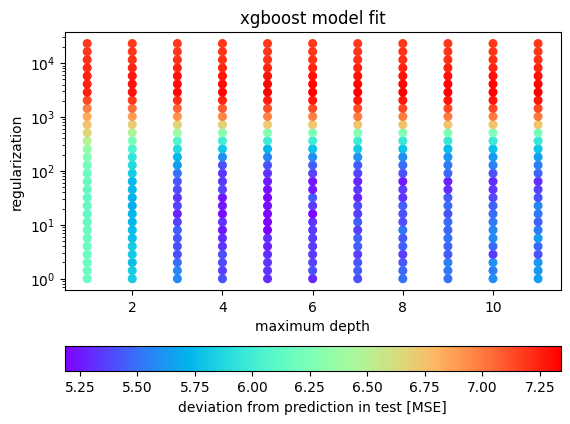

In [151]:

plt.scatter(x=xres[1], y=xres[0], c=xres[3],s=30, cmap="rainbow")
plt.colorbar(label="deviation from prediction in test [MSE]", orientation="horizontal")
plt.xlabel("maximum depth")
plt.ylabel("regularization")
plt.yscale("log")
plt.title("xgboost model fit")
min2=np.min(xres[3])
for i in range(xres.shape[1]):
    for j in range(xres.shape[2]):
        if xres[3,i,j]==min2:
            print(xres[0:2,i,j])

Averaging 6 cases makes that there is not much random variation as it should be.
There the best is much less good, at best 5.1. The best regl

In [152]:
xmodel1=XGBRegressor(max_depth=5,reg_alpha=7.99275419).fit(allres3[19:38,:,0].T,np.mean(allres3[40,:,:],1))

In [178]:
seed(1)
n_it=6000000
rand2 =rand(n_it,19)*0.2-0.1
xpred=xmodel1.predict(rand2)
c=0
for i in range(len(xpred)):
    if xpred[i]<55:
        c+=1
print(c)
print(min(xpred))

1555
25.21419


In [191]:
selmodels=np.zeros((19,1555))
xselmodels=np.zeros((1555))
c=0
for i in range(len(xpred)):
    if xpred[i]<55:
        selmodels[:,c]=rand2[i,:]
        xselmodels[c]=xpred[i]
        c+=1
print(c)        
#np.save("xgb_sel1.txt",selmodels)       
#np.save("pred_xgb_sel1.npy",xselmodels) 

1555


Below I build a function which gets win fractions running two lists of input models in all possible combinations. 

In [2]:
#does comparisons against a number of cases
#open_vars and co and and are lists of the variables to be used 
#open_21 and teh on are the 
#reliazations are number of models tried in one, trials are number of MC models for level 21
#wfrac when it aborts early
#wfrac2 performance of worst case .
def many_comparisons(open_vars,discard_vars,value_vars,open_21,discard_21,value_21,realizations,wfrac=0.10,wfrac2=0.551):
    n_it=realizations
    trials=len(open_21)
    results=np.zeros((41,trials,len(open_vars)))
    for j in range(trials):
        print(f"doing case {j} for level 21")
        #create random values for level 21 within the ranges, save are used for all level 20 models
        level21_open_variable=np.array(open_21[j])
        level21_discard_variable=np.array(discard_21[j])
        level21_value_variable=np.array(value_21[j])          
        for k in range(len(open_vars)):
            print(f"trying case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])            
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            it_counter=0
            start_time=time.time()
            n_it1=n_it
            if n_it1>22:
                n_it1=22
            #22 always     
            for i in range(n_it1):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                it_counter+=1
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1
            #98% ownside win conditions tested here   2.33 sigma   stops early when new model clearly bad or good 
            while it_counter<n_it and abs((win20-it_counter/2)/np.sqrt(it_counter))<2.33:  
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                it_counter+=1
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1                
            #now checking whether 98% sigficant on bad performance        
            results[38,j,k]=it_counter
            results[39,j,k]=win20
            results[40,j,k]=100*win20/it_counter         
            stop_time=time.time()
            print(f"{it_counter} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(results[40,j,k],1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[40,j,:]),1)} %") 
        if np.mean(results[40,j,:]/100)<wfrac and np.max(results[40,j,:]/100)<wfrac2:
            print("better model found")
            if j==0:
                return True, results[:,j,:], results[:,j,:]
            else:
                #give back fit converged or not, best models, all models 
                return True, results[:,j,:], results[:,0:j+1,:]
    print("no better model found") 
    #second parameter is noen will not be used later
    return False, None, results 

In [4]:
print(5.5*3600/(1263/20))

313.5391923990499


Now I am running the existing models against the model created using xgboost. 

In [16]:
allres2=np.load("mc_v9_all.npy")
c=0
list_open7=[]
list_discard7=[]
list_value7=[]
for i in range(850):
    if np.mean(allres2[40,i,4:6])<45 and np.max(allres2[40,i,:])<60:
        list_open7.append(allres2[19:25,i,0])
        list_discard7.append(allres2[25:31,i,0])        
        list_value7.append(allres2[31:38,i,0])   
print(list_open7)
xres1=np.load("xgb_sel1.txt.npy")
c=0
list_openx1=[]
list_discardx1=[]
list_valuex1=[]
for i in range(340,950):
        list_openx1.append(xres1[0:6,i])
        list_discardx1.append(xres1[6:12,i])        
        list_valuex1.append(xres1[12:19,i])   
print(list_openx1[0:7])

start_time=time.time()
boolean,bestres,allres=many_comparisons(list_open7,list_discard7,list_value7,list_openx1,list_discardx1,list_valuex1,50,wfrac=0.001,wfrac2=0.002)
#v10 on purpose impossible crieteria to just run all iterations with predictable operation duration
#mcx_v1_all.npy does first 20 
#v2 is 20 to 340 
#v3 is 340 tom 950
np.save("mcx_v3_all.npy",allres)
stop_time=time.time()
print(f"ran for {np.round(stop_time-start_time,2)} seconds")       
#first 20 needed 1263.93 second clearly slower , slower model or computer more occupied? , or just taht models are better
#ran for 16865.23 seconds for 320

[array([-0.06831686,  0.02731667,  0.06433668, -0.06519184, -0.06138129,
       -0.02530104]), array([ 0.09651646, -0.02684305,  0.00183673, -0.0894212 , -0.08815541,
        0.03519835]), array([-0.017706  , -0.07898665, -0.03564065, -0.08886795,  0.04114419,
        0.02847683]), array([-0.06021169, -0.0902781 , -0.00155455, -0.01841127,  0.01388234,
       -0.05260926]), array([-0.00082434,  0.04036975, -0.09866433, -0.08950707, -0.00375526,
       -0.06464979]), array([-6.53596770e-05, -6.90977851e-02,  1.60961960e-02, -4.81552487e-03,
       -7.62965770e-02, -1.97269779e-02])]
[array([ 0.07167175, -0.04843659, -0.0067574 ,  0.00456917, -0.05073618,
       -0.0735937 ]), array([ 0.00187748, -0.08679945, -0.07414245, -0.01315587,  0.02386005,
       -0.09965818]), array([ 0.02291818,  0.05359993, -0.06210101, -0.07919192, -0.06676402,
       -0.09224651]), array([-0.05571683, -0.02747073, -0.091028  , -0.00364757, -0.05960689,
       -0.08419466]), array([-0.01822643, -0.09614289,  

50 games need 11.073 seconds
level 20 won to 64.0 %
trying case 2 for level 20
50 games need 9.475 seconds
level 20 won to 64.0 %
trying case 3 for level 20
50 games need 12.288 seconds
level 20 won to 60.0 %
trying case 4 for level 20
50 games need 13.178 seconds
level 20 won to 60.0 %
trying case 5 for level 20
50 games need 11.307 seconds
level 20 won to 68.0 %
level 20 won in average to 61.3 %
doing case 14 for level 21
trying case 0 for level 20
50 games need 8.674 seconds
level 20 won to 54.0 %
trying case 1 for level 20
50 games need 8.069 seconds
level 20 won to 56.0 %
trying case 2 for level 20
50 games need 7.402 seconds
level 20 won to 58.0 %
trying case 3 for level 20
50 games need 10.124 seconds
level 20 won to 48.0 %
trying case 4 for level 20
50 games need 10.654 seconds
level 20 won to 56.0 %
trying case 5 for level 20
50 games need 9.063 seconds
level 20 won to 32.0 %
level 20 won in average to 50.7 %
doing case 15 for level 21
trying case 0 for level 20
50 games need 

26 games need 4.221 seconds
level 20 won to 96.2 %
trying case 5 for level 20
46 games need 6.381 seconds
level 20 won to 84.8 %
level 20 won in average to 90.7 %
doing case 29 for level 21
trying case 0 for level 20
50 games need 12.781 seconds
level 20 won to 62.0 %
trying case 1 for level 20
43 games need 9.846 seconds
level 20 won to 86.0 %
trying case 2 for level 20
50 games need 10.725 seconds
level 20 won to 76.0 %
trying case 3 for level 20
50 games need 12.805 seconds
level 20 won to 78.0 %
trying case 4 for level 20
50 games need 13.925 seconds
level 20 won to 78.0 %
trying case 5 for level 20
50 games need 11.211 seconds
level 20 won to 76.0 %
level 20 won in average to 76.0 %
doing case 30 for level 21
trying case 0 for level 20
50 games need 12.737 seconds
level 20 won to 46.0 %
trying case 1 for level 20
50 games need 11.656 seconds
level 20 won to 42.0 %
trying case 2 for level 20
50 games need 11.024 seconds
level 20 won to 52.0 %
trying case 3 for level 20
50 games nee

50 games need 7.168 seconds
level 20 won to 62.0 %
trying case 1 for level 20
50 games need 6.938 seconds
level 20 won to 68.0 %
trying case 2 for level 20
49 games need 5.298 seconds
level 20 won to 83.7 %
trying case 3 for level 20
50 games need 8.473 seconds
level 20 won to 56.0 %
trying case 4 for level 20
50 games need 8.98 seconds
level 20 won to 52.0 %
trying case 5 for level 20
50 games need 8.597 seconds
level 20 won to 62.0 %
level 20 won in average to 63.9 %
doing case 45 for level 21
trying case 0 for level 20
50 games need 11.512 seconds
level 20 won to 76.0 %
trying case 1 for level 20
50 games need 10.24 seconds
level 20 won to 54.0 %
trying case 2 for level 20
50 games need 9.43 seconds
level 20 won to 56.0 %
trying case 3 for level 20
50 games need 11.471 seconds
level 20 won to 54.0 %
trying case 4 for level 20
50 games need 12.797 seconds
level 20 won to 42.0 %
trying case 5 for level 20
50 games need 11.25 seconds
level 20 won to 50.0 %
level 20 won in average to 55

50 games need 9.56 seconds
level 20 won to 60.0 %
trying case 4 for level 20
50 games need 8.491 seconds
level 20 won to 46.0 %
trying case 5 for level 20
50 games need 8.98 seconds
level 20 won to 66.0 %
level 20 won in average to 61.0 %
doing case 60 for level 21
trying case 0 for level 20
50 games need 9.457 seconds
level 20 won to 58.0 %
trying case 1 for level 20
50 games need 8.832 seconds
level 20 won to 58.0 %
trying case 2 for level 20
50 games need 7.835 seconds
level 20 won to 64.0 %
trying case 3 for level 20
50 games need 9.694 seconds
level 20 won to 68.0 %
trying case 4 for level 20
50 games need 10.504 seconds
level 20 won to 60.0 %
trying case 5 for level 20
50 games need 9.28 seconds
level 20 won to 64.0 %
level 20 won in average to 62.0 %
doing case 61 for level 21
trying case 0 for level 20
50 games need 10.208 seconds
level 20 won to 60.0 %
trying case 1 for level 20
50 games need 9.033 seconds
level 20 won to 48.0 %
trying case 2 for level 20
50 games need 8.072 s

50 games need 7.094 seconds
level 20 won to 58.0 %
trying case 1 for level 20
50 games need 6.732 seconds
level 20 won to 66.0 %
trying case 2 for level 20
26 games need 2.94 seconds
level 20 won to 96.2 %
trying case 3 for level 20
50 games need 8.702 seconds
level 20 won to 70.0 %
trying case 4 for level 20
50 games need 8.273 seconds
level 20 won to 70.0 %
trying case 5 for level 20
50 games need 8.193 seconds
level 20 won to 60.0 %
level 20 won in average to 70.0 %
doing case 76 for level 21
trying case 0 for level 20
50 games need 10.151 seconds
level 20 won to 44.0 %
trying case 1 for level 20
50 games need 9.348 seconds
level 20 won to 38.0 %
trying case 2 for level 20
50 games need 8.449 seconds
level 20 won to 46.0 %
trying case 3 for level 20
50 games need 8.949 seconds
level 20 won to 24.0 %
trying case 4 for level 20
50 games need 9.325 seconds
level 20 won to 30.0 %
trying case 5 for level 20
50 games need 8.701 seconds
level 20 won to 38.0 %
level 20 won in average to 36.

50 games need 8.01 seconds
level 20 won to 58.0 %
trying case 5 for level 20
50 games need 8.393 seconds
level 20 won to 52.0 %
level 20 won in average to 63.3 %
doing case 91 for level 21
trying case 0 for level 20
50 games need 11.096 seconds
level 20 won to 60.0 %
trying case 1 for level 20
50 games need 10.302 seconds
level 20 won to 64.0 %
trying case 2 for level 20
50 games need 8.912 seconds
level 20 won to 62.0 %
trying case 3 for level 20
50 games need 10.654 seconds
level 20 won to 74.0 %
trying case 4 for level 20
50 games need 10.943 seconds
level 20 won to 56.0 %
trying case 5 for level 20
50 games need 10.563 seconds
level 20 won to 58.0 %
level 20 won in average to 62.3 %
doing case 92 for level 21
trying case 0 for level 20
43 games need 2.894 seconds
level 20 won to 86.0 %
trying case 1 for level 20
50 games need 3.111 seconds
level 20 won to 80.0 %
trying case 2 for level 20
22 games need 1.211 seconds
level 20 won to 100.0 %
trying case 3 for level 20
49 games need 3

50 games need 4.236 seconds
level 20 won to 82.0 %
trying case 2 for level 20
22 games need 1.476 seconds
level 20 won to 100.0 %
trying case 3 for level 20
50 games need 5.045 seconds
level 20 won to 68.0 %
trying case 4 for level 20
50 games need 5.954 seconds
level 20 won to 58.0 %
trying case 5 for level 20
50 games need 5.378 seconds
level 20 won to 64.0 %
level 20 won in average to 74.7 %
doing case 107 for level 21
trying case 0 for level 20
50 games need 13.165 seconds
level 20 won to 64.0 %
trying case 1 for level 20
50 games need 10.988 seconds
level 20 won to 64.0 %
trying case 2 for level 20
50 games need 11.16 seconds
level 20 won to 66.0 %
trying case 3 for level 20
50 games need 12.607 seconds
level 20 won to 60.0 %
trying case 4 for level 20
50 games need 13.741 seconds
level 20 won to 66.0 %
trying case 5 for level 20
50 games need 11.843 seconds
level 20 won to 54.0 %
level 20 won in average to 62.3 %
doing case 108 for level 21
trying case 0 for level 20
50 games nee

50 games need 13.704 seconds
level 20 won to 78.0 %
trying case 5 for level 20
50 games need 11.799 seconds
level 20 won to 74.0 %
level 20 won in average to 78.5 %
doing case 122 for level 21
trying case 0 for level 20
50 games need 12.791 seconds
level 20 won to 70.0 %
trying case 1 for level 20
50 games need 10.96 seconds
level 20 won to 62.0 %
trying case 2 for level 20
43 games need 9.4 seconds
level 20 won to 86.0 %
trying case 3 for level 20
50 games need 12.882 seconds
level 20 won to 70.0 %
trying case 4 for level 20
50 games need 14.022 seconds
level 20 won to 80.0 %
trying case 5 for level 20
50 games need 11.25 seconds
level 20 won to 74.0 %
level 20 won in average to 73.7 %
doing case 123 for level 21
trying case 0 for level 20
50 games need 6.816 seconds
level 20 won to 72.0 %
trying case 1 for level 20
50 games need 6.286 seconds
level 20 won to 80.0 %
trying case 2 for level 20
22 games need 2.405 seconds
level 20 won to 100.0 %
trying case 3 for level 20
50 games need 

50 games need 8.395 seconds
level 20 won to 64.0 %
trying case 1 for level 20
50 games need 8.594 seconds
level 20 won to 60.0 %
trying case 2 for level 20
50 games need 7.283 seconds
level 20 won to 72.0 %
trying case 3 for level 20
50 games need 9.016 seconds
level 20 won to 44.0 %
trying case 4 for level 20
50 games need 9.685 seconds
level 20 won to 48.0 %
trying case 5 for level 20
50 games need 8.544 seconds
level 20 won to 60.0 %
level 20 won in average to 58.0 %
doing case 138 for level 21
trying case 0 for level 20
50 games need 11.214 seconds
level 20 won to 34.0 %
trying case 1 for level 20
50 games need 9.982 seconds
level 20 won to 32.0 %
trying case 2 for level 20
50 games need 9.858 seconds
level 20 won to 40.0 %
trying case 3 for level 20
50 games need 10.694 seconds
level 20 won to 46.0 %
trying case 4 for level 20
50 games need 11.3 seconds
level 20 won to 32.0 %
trying case 5 for level 20
50 games need 10.312 seconds
level 20 won to 54.0 %
level 20 won in average to 

50 games need 7.522 seconds
level 20 won to 70.0 %
trying case 4 for level 20
50 games need 8.86 seconds
level 20 won to 38.0 %
trying case 5 for level 20
50 games need 7.888 seconds
level 20 won to 56.0 %
level 20 won in average to 61.0 %
doing case 153 for level 21
trying case 0 for level 20
50 games need 12.237 seconds
level 20 won to 50.0 %
trying case 1 for level 20
50 games need 9.706 seconds
level 20 won to 40.0 %
trying case 2 for level 20
50 games need 9.58 seconds
level 20 won to 48.0 %
trying case 3 for level 20
50 games need 11.892 seconds
level 20 won to 54.0 %
trying case 4 for level 20
50 games need 11.872 seconds
level 20 won to 38.0 %
trying case 5 for level 20
50 games need 11.071 seconds
level 20 won to 46.0 %
level 20 won in average to 46.0 %
doing case 154 for level 21
trying case 0 for level 20
50 games need 10.218 seconds
level 20 won to 50.0 %
trying case 1 for level 20
50 games need 9.723 seconds
level 20 won to 46.0 %
trying case 2 for level 20
50 games need 8

50 games need 7.248 seconds
level 20 won to 40.0 %
trying case 1 for level 20
50 games need 7.231 seconds
level 20 won to 50.0 %
trying case 2 for level 20
50 games need 7.637 seconds
level 20 won to 52.0 %
trying case 3 for level 20
50 games need 7.398 seconds
level 20 won to 54.0 %
trying case 4 for level 20
50 games need 6.327 seconds
level 20 won to 30.0 %
trying case 5 for level 20
50 games need 6.859 seconds
level 20 won to 52.0 %
level 20 won in average to 46.3 %
doing case 169 for level 21
trying case 0 for level 20
50 games need 11.993 seconds
level 20 won to 50.0 %
trying case 1 for level 20
50 games need 10.623 seconds
level 20 won to 56.0 %
trying case 2 for level 20
50 games need 11.013 seconds
level 20 won to 52.0 %
trying case 3 for level 20
50 games need 11.599 seconds
level 20 won to 54.0 %
trying case 4 for level 20
50 games need 12.208 seconds
level 20 won to 50.0 %
trying case 5 for level 20
50 games need 10.092 seconds
level 20 won to 56.0 %
level 20 won in average

50 games need 12.086 seconds
level 20 won to 54.0 %
trying case 4 for level 20
50 games need 13.686 seconds
level 20 won to 32.0 %
trying case 5 for level 20
50 games need 11.388 seconds
level 20 won to 66.0 %
level 20 won in average to 51.7 %
doing case 184 for level 21
trying case 0 for level 20
50 games need 13.629 seconds
level 20 won to 46.0 %
trying case 1 for level 20
50 games need 10.882 seconds
level 20 won to 50.0 %
trying case 2 for level 20
50 games need 11.297 seconds
level 20 won to 38.0 %
trying case 3 for level 20
50 games need 12.771 seconds
level 20 won to 48.0 %
trying case 4 for level 20
50 games need 13.426 seconds
level 20 won to 52.0 %
trying case 5 for level 20
50 games need 10.905 seconds
level 20 won to 58.0 %
level 20 won in average to 48.7 %
doing case 185 for level 21
trying case 0 for level 20
22 games need 2.209 seconds
level 20 won to 100.0 %
trying case 1 for level 20
49 games need 4.192 seconds
level 20 won to 83.7 %
trying case 2 for level 20
22 games

50 games need 6.519 seconds
level 20 won to 70.0 %
trying case 1 for level 20
50 games need 6.973 seconds
level 20 won to 68.0 %
trying case 2 for level 20
50 games need 6.389 seconds
level 20 won to 80.0 %
trying case 3 for level 20
50 games need 6.8 seconds
level 20 won to 74.0 %
trying case 4 for level 20
50 games need 7.345 seconds
level 20 won to 48.0 %
trying case 5 for level 20
50 games need 6.37 seconds
level 20 won to 72.0 %
level 20 won in average to 68.7 %
doing case 200 for level 21
trying case 0 for level 20
50 games need 10.91 seconds
level 20 won to 56.0 %
trying case 1 for level 20
50 games need 8.815 seconds
level 20 won to 40.0 %
trying case 2 for level 20
50 games need 8.85 seconds
level 20 won to 46.0 %
trying case 3 for level 20
50 games need 10.64 seconds
level 20 won to 56.0 %
trying case 4 for level 20
50 games need 11.127 seconds
level 20 won to 34.0 %
trying case 5 for level 20
50 games need 9.34 seconds
level 20 won to 36.0 %
level 20 won in average to 44.7 %

50 games need 6.188 seconds
level 20 won to 64.0 %
trying case 4 for level 20
50 games need 5.736 seconds
level 20 won to 48.0 %
trying case 5 for level 20
50 games need 6.41 seconds
level 20 won to 68.0 %
level 20 won in average to 67.7 %
doing case 215 for level 21
trying case 0 for level 20
50 games need 11.497 seconds
level 20 won to 32.0 %
trying case 1 for level 20
50 games need 10.313 seconds
level 20 won to 46.0 %
trying case 2 for level 20
50 games need 9.753 seconds
level 20 won to 56.0 %
trying case 3 for level 20
50 games need 10.907 seconds
level 20 won to 50.0 %
trying case 4 for level 20
50 games need 11.606 seconds
level 20 won to 50.0 %
trying case 5 for level 20
50 games need 10.634 seconds
level 20 won to 40.0 %
level 20 won in average to 45.7 %
doing case 216 for level 21
trying case 0 for level 20
50 games need 12.654 seconds
level 20 won to 42.0 %
trying case 1 for level 20
50 games need 9.779 seconds
level 20 won to 38.0 %
trying case 2 for level 20
50 games need

50 games need 9.37 seconds
level 20 won to 60.0 %
trying case 1 for level 20
50 games need 8.326 seconds
level 20 won to 54.0 %
trying case 2 for level 20
50 games need 7.933 seconds
level 20 won to 64.0 %
trying case 3 for level 20
50 games need 9.253 seconds
level 20 won to 58.0 %
trying case 4 for level 20
50 games need 11.133 seconds
level 20 won to 38.0 %
trying case 5 for level 20
50 games need 9.314 seconds
level 20 won to 52.0 %
level 20 won in average to 54.3 %
doing case 231 for level 21
trying case 0 for level 20
50 games need 6.671 seconds
level 20 won to 78.0 %
trying case 1 for level 20
50 games need 7.269 seconds
level 20 won to 80.0 %
trying case 2 for level 20
50 games need 6.155 seconds
level 20 won to 80.0 %
trying case 3 for level 20
50 games need 7.466 seconds
level 20 won to 70.0 %
trying case 4 for level 20
50 games need 7.978 seconds
level 20 won to 70.0 %
trying case 5 for level 20
50 games need 7.617 seconds
level 20 won to 72.0 %
level 20 won in average to 75

50 games need 10.554 seconds
level 20 won to 56.0 %
trying case 4 for level 20
50 games need 10.324 seconds
level 20 won to 64.0 %
trying case 5 for level 20
50 games need 10.954 seconds
level 20 won to 54.0 %
level 20 won in average to 57.7 %
doing case 246 for level 21
trying case 0 for level 20
50 games need 4.7 seconds
level 20 won to 64.0 %
trying case 1 for level 20
50 games need 5.134 seconds
level 20 won to 60.0 %
trying case 2 for level 20
50 games need 5.447 seconds
level 20 won to 80.0 %
trying case 3 for level 20
50 games need 4.708 seconds
level 20 won to 66.0 %
trying case 4 for level 20
50 games need 4.853 seconds
level 20 won to 52.0 %
trying case 5 for level 20
50 games need 5.022 seconds
level 20 won to 66.0 %
level 20 won in average to 64.7 %
doing case 247 for level 21
trying case 0 for level 20
43 games need 3.676 seconds
level 20 won to 86.0 %
trying case 1 for level 20
36 games need 2.768 seconds
level 20 won to 88.9 %
trying case 2 for level 20
22 games need 1.2

22 games need 2.972 seconds
level 20 won to 100.0 %
trying case 1 for level 20
26 games need 3.643 seconds
level 20 won to 96.2 %
trying case 2 for level 20
33 games need 4.268 seconds
level 20 won to 90.9 %
trying case 3 for level 20
22 games need 2.946 seconds
level 20 won to 100.0 %
trying case 4 for level 20
30 games need 4.427 seconds
level 20 won to 93.3 %
trying case 5 for level 20
30 games need 4.449 seconds
level 20 won to 93.3 %
level 20 won in average to 95.6 %
doing case 262 for level 21
trying case 0 for level 20
36 games need 8.125 seconds
level 20 won to 88.9 %
trying case 1 for level 20
50 games need 10.806 seconds
level 20 won to 82.0 %
trying case 2 for level 20
22 games need 4.731 seconds
level 20 won to 100.0 %
trying case 3 for level 20
26 games need 6.098 seconds
level 20 won to 96.2 %
trying case 4 for level 20
46 games need 10.896 seconds
level 20 won to 84.8 %
trying case 5 for level 20
33 games need 6.376 seconds
level 20 won to 90.9 %
level 20 won in average 

50 games need 9.923 seconds
level 20 won to 60.0 %
trying case 4 for level 20
50 games need 10.757 seconds
level 20 won to 44.0 %
trying case 5 for level 20
50 games need 9.524 seconds
level 20 won to 62.0 %
level 20 won in average to 53.7 %
doing case 277 for level 21
trying case 0 for level 20
50 games need 12.946 seconds
level 20 won to 60.0 %
trying case 1 for level 20
50 games need 11.525 seconds
level 20 won to 60.0 %
trying case 2 for level 20
50 games need 11.257 seconds
level 20 won to 56.0 %
trying case 3 for level 20
50 games need 11.287 seconds
level 20 won to 52.0 %
trying case 4 for level 20
50 games need 10.995 seconds
level 20 won to 52.0 %
trying case 5 for level 20
50 games need 10.184 seconds
level 20 won to 46.0 %
level 20 won in average to 54.3 %
doing case 278 for level 21
trying case 0 for level 20
50 games need 11.538 seconds
level 20 won to 62.0 %
trying case 1 for level 20
50 games need 9.506 seconds
level 20 won to 64.0 %
trying case 2 for level 20
50 games n

50 games need 6.34 seconds
level 20 won to 74.0 %
trying case 1 for level 20
50 games need 5.802 seconds
level 20 won to 72.0 %
trying case 2 for level 20
49 games need 5.152 seconds
level 20 won to 83.7 %
trying case 3 for level 20
50 games need 6.833 seconds
level 20 won to 64.0 %
trying case 4 for level 20
50 games need 6.767 seconds
level 20 won to 52.0 %
trying case 5 for level 20
50 games need 6.758 seconds
level 20 won to 62.0 %
level 20 won in average to 67.9 %
doing case 293 for level 21
trying case 0 for level 20
50 games need 7.354 seconds
level 20 won to 62.0 %
trying case 1 for level 20
50 games need 7.093 seconds
level 20 won to 80.0 %
trying case 2 for level 20
50 games need 5.779 seconds
level 20 won to 78.0 %
trying case 3 for level 20
50 games need 8.222 seconds
level 20 won to 52.0 %
trying case 4 for level 20
50 games need 8.172 seconds
level 20 won to 36.0 %
trying case 5 for level 20
50 games need 7.311 seconds
level 20 won to 50.0 %
level 20 won in average to 59.

30 games need 2.427 seconds
level 20 won to 93.3 %
trying case 4 for level 20
50 games need 4.385 seconds
level 20 won to 74.0 %
trying case 5 for level 20
26 games need 1.902 seconds
level 20 won to 96.2 %
level 20 won in average to 92.4 %
doing case 308 for level 21
trying case 0 for level 20
50 games need 6.328 seconds
level 20 won to 48.0 %
trying case 1 for level 20
50 games need 6.281 seconds
level 20 won to 54.0 %
trying case 2 for level 20
50 games need 5.459 seconds
level 20 won to 76.0 %
trying case 3 for level 20
50 games need 6.822 seconds
level 20 won to 48.0 %
trying case 4 for level 20
50 games need 6.666 seconds
level 20 won to 36.0 %
trying case 5 for level 20
50 games need 6.829 seconds
level 20 won to 46.0 %
level 20 won in average to 51.3 %
doing case 309 for level 21
trying case 0 for level 20
50 games need 7.915 seconds
level 20 won to 56.0 %
trying case 1 for level 20
50 games need 7.474 seconds
level 20 won to 54.0 %
trying case 2 for level 20
50 games need 8.19

50 games need 10.884 seconds
level 20 won to 82.0 %
trying case 1 for level 20
46 games need 9.968 seconds
level 20 won to 84.8 %
trying case 2 for level 20
36 games need 7.527 seconds
level 20 won to 88.9 %
trying case 3 for level 20
50 games need 12.245 seconds
level 20 won to 82.0 %
trying case 4 for level 20
36 games need 8.236 seconds
level 20 won to 88.9 %
trying case 5 for level 20
50 games need 9.872 seconds
level 20 won to 78.0 %
level 20 won in average to 84.1 %
doing case 324 for level 21
trying case 0 for level 20
50 games need 5.937 seconds
level 20 won to 66.0 %
trying case 1 for level 20
50 games need 5.699 seconds
level 20 won to 50.0 %
trying case 2 for level 20
50 games need 6.737 seconds
level 20 won to 64.0 %
trying case 3 for level 20
50 games need 5.047 seconds
level 20 won to 60.0 %
trying case 4 for level 20
50 games need 4.946 seconds
level 20 won to 66.0 %
trying case 5 for level 20
50 games need 5.38 seconds
level 20 won to 58.0 %
level 20 won in average to 6

49 games need 3.467 seconds
level 20 won to 83.7 %
trying case 4 for level 20
50 games need 3.512 seconds
level 20 won to 68.0 %
trying case 5 for level 20
50 games need 3.31 seconds
level 20 won to 80.0 %
level 20 won in average to 83.2 %
doing case 339 for level 21
trying case 0 for level 20
50 games need 12.976 seconds
level 20 won to 44.0 %
trying case 1 for level 20
50 games need 11.475 seconds
level 20 won to 38.0 %
trying case 2 for level 20
50 games need 12.146 seconds
level 20 won to 56.0 %
trying case 3 for level 20
50 games need 12.171 seconds
level 20 won to 50.0 %
trying case 4 for level 20
50 games need 13.586 seconds
level 20 won to 66.0 %
trying case 5 for level 20
50 games need 12.4 seconds
level 20 won to 50.0 %
level 20 won in average to 50.7 %
doing case 340 for level 21
trying case 0 for level 20
50 games need 8.604 seconds
level 20 won to 76.0 %
trying case 1 for level 20
50 games need 7.346 seconds
level 20 won to 78.0 %
trying case 2 for level 20
50 games need 6

50 games need 11.431 seconds
level 20 won to 38.0 %
trying case 1 for level 20
50 games need 10.467 seconds
level 20 won to 60.0 %
trying case 2 for level 20
50 games need 9.945 seconds
level 20 won to 50.0 %
trying case 3 for level 20
50 games need 10.972 seconds
level 20 won to 50.0 %
trying case 4 for level 20
50 games need 12.072 seconds
level 20 won to 38.0 %
trying case 5 for level 20
50 games need 10.654 seconds
level 20 won to 42.0 %
level 20 won in average to 46.3 %
doing case 355 for level 21
trying case 0 for level 20
50 games need 6.759 seconds
level 20 won to 52.0 %
trying case 1 for level 20
50 games need 6.124 seconds
level 20 won to 52.0 %
trying case 2 for level 20
46 games need 5.653 seconds
level 20 won to 84.8 %
trying case 3 for level 20
50 games need 6.87 seconds
level 20 won to 60.0 %
trying case 4 for level 20
50 games need 6.841 seconds
level 20 won to 44.0 %
trying case 5 for level 20
50 games need 6.772 seconds
level 20 won to 76.0 %
level 20 won in average t

50 games need 11.989 seconds
level 20 won to 54.0 %
trying case 4 for level 20
50 games need 13.739 seconds
level 20 won to 48.0 %
trying case 5 for level 20
50 games need 12.038 seconds
level 20 won to 56.0 %
level 20 won in average to 58.7 %
doing case 370 for level 21
trying case 0 for level 20
50 games need 8.065 seconds
level 20 won to 62.0 %
trying case 1 for level 20
50 games need 7.322 seconds
level 20 won to 62.0 %
trying case 2 for level 20
50 games need 7.016 seconds
level 20 won to 74.0 %
trying case 3 for level 20
50 games need 8.308 seconds
level 20 won to 50.0 %
trying case 4 for level 20
50 games need 8.142 seconds
level 20 won to 44.0 %
trying case 5 for level 20
50 games need 8.141 seconds
level 20 won to 44.0 %
level 20 won in average to 56.0 %
doing case 371 for level 21
trying case 0 for level 20
50 games need 12.328 seconds
level 20 won to 58.0 %
trying case 1 for level 20
50 games need 11.156 seconds
level 20 won to 52.0 %
trying case 2 for level 20
50 games need

50 games need 7.152 seconds
level 20 won to 70.0 %
trying case 1 for level 20
40 games need 4.434 seconds
level 20 won to 87.5 %
trying case 2 for level 20
22 games need 2.144 seconds
level 20 won to 100.0 %
trying case 3 for level 20
50 games need 7.244 seconds
level 20 won to 68.0 %
trying case 4 for level 20
50 games need 7.714 seconds
level 20 won to 34.0 %
trying case 5 for level 20
50 games need 7.104 seconds
level 20 won to 74.0 %
level 20 won in average to 72.2 %
doing case 386 for level 21
trying case 0 for level 20
50 games need 10.335 seconds
level 20 won to 52.0 %
trying case 1 for level 20
50 games need 9.892 seconds
level 20 won to 60.0 %
trying case 2 for level 20
50 games need 8.753 seconds
level 20 won to 74.0 %
trying case 3 for level 20
50 games need 11.274 seconds
level 20 won to 72.0 %
trying case 4 for level 20
50 games need 12.029 seconds
level 20 won to 52.0 %
trying case 5 for level 20
50 games need 10.067 seconds
level 20 won to 52.0 %
level 20 won in average 

50 games need 6.326 seconds
level 20 won to 56.0 %
trying case 4 for level 20
50 games need 6.134 seconds
level 20 won to 36.0 %
trying case 5 for level 20
50 games need 6.462 seconds
level 20 won to 76.0 %
level 20 won in average to 63.5 %
doing case 401 for level 21
trying case 0 for level 20
46 games need 3.888 seconds
level 20 won to 84.8 %
trying case 1 for level 20
40 games need 3.266 seconds
level 20 won to 87.5 %
trying case 2 for level 20
26 games need 1.914 seconds
level 20 won to 96.2 %
trying case 3 for level 20
50 games need 5.233 seconds
level 20 won to 70.0 %
trying case 4 for level 20
50 games need 5.835 seconds
level 20 won to 60.0 %
trying case 5 for level 20
50 games need 4.991 seconds
level 20 won to 80.0 %
level 20 won in average to 79.7 %
doing case 402 for level 21
trying case 0 for level 20
46 games need 6.011 seconds
level 20 won to 84.8 %
trying case 1 for level 20
50 games need 6.033 seconds
level 20 won to 80.0 %
trying case 2 for level 20
22 games need 2.16

50 games need 10.103 seconds
level 20 won to 72.0 %
trying case 1 for level 20
50 games need 9.924 seconds
level 20 won to 60.0 %
trying case 2 for level 20
50 games need 8.487 seconds
level 20 won to 74.0 %
trying case 3 for level 20
50 games need 10.38 seconds
level 20 won to 72.0 %
trying case 4 for level 20
50 games need 10.899 seconds
level 20 won to 50.0 %
trying case 5 for level 20
50 games need 10.818 seconds
level 20 won to 52.0 %
level 20 won in average to 63.3 %
doing case 417 for level 21
trying case 0 for level 20
50 games need 11.756 seconds
level 20 won to 50.0 %
trying case 1 for level 20
50 games need 10.766 seconds
level 20 won to 68.0 %
trying case 2 for level 20
50 games need 10.408 seconds
level 20 won to 64.0 %
trying case 3 for level 20
50 games need 12.717 seconds
level 20 won to 52.0 %
trying case 4 for level 20
50 games need 13.566 seconds
level 20 won to 46.0 %
trying case 5 for level 20
50 games need 10.184 seconds
level 20 won to 48.0 %
level 20 won in aver

50 games need 12.102 seconds
level 20 won to 70.0 %
trying case 4 for level 20
50 games need 14.398 seconds
level 20 won to 74.0 %
trying case 5 for level 20
50 games need 11.023 seconds
level 20 won to 56.0 %
level 20 won in average to 67.0 %
doing case 432 for level 21
trying case 0 for level 20
50 games need 5.507 seconds
level 20 won to 64.0 %
trying case 1 for level 20
50 games need 5.967 seconds
level 20 won to 66.0 %
trying case 2 for level 20
50 games need 5.026 seconds
level 20 won to 72.0 %
trying case 3 for level 20
50 games need 5.859 seconds
level 20 won to 70.0 %
trying case 4 for level 20
50 games need 6.042 seconds
level 20 won to 60.0 %
trying case 5 for level 20
50 games need 5.974 seconds
level 20 won to 58.0 %
level 20 won in average to 65.0 %
doing case 433 for level 21
trying case 0 for level 20
50 games need 12.374 seconds
level 20 won to 32.0 %
trying case 1 for level 20
50 games need 11.062 seconds
level 20 won to 40.0 %
trying case 2 for level 20
50 games need

50 games need 10.397 seconds
level 20 won to 38.0 %
trying case 1 for level 20
50 games need 8.785 seconds
level 20 won to 36.0 %
trying case 2 for level 20
50 games need 9.366 seconds
level 20 won to 46.0 %
trying case 3 for level 20
50 games need 10.16 seconds
level 20 won to 48.0 %
trying case 4 for level 20
50 games need 10.083 seconds
level 20 won to 32.0 %
trying case 5 for level 20
50 games need 9.034 seconds
level 20 won to 44.0 %
level 20 won in average to 40.7 %
doing case 448 for level 21
trying case 0 for level 20
50 games need 12.115 seconds
level 20 won to 62.0 %
trying case 1 for level 20
50 games need 11.643 seconds
level 20 won to 40.0 %
trying case 2 for level 20
50 games need 11.206 seconds
level 20 won to 76.0 %
trying case 3 for level 20
50 games need 12.323 seconds
level 20 won to 68.0 %
trying case 4 for level 20
50 games need 13.646 seconds
level 20 won to 78.0 %
trying case 5 for level 20
50 games need 11.578 seconds
level 20 won to 62.0 %
level 20 won in avera

50 games need 11.977 seconds
level 20 won to 56.0 %
trying case 4 for level 20
50 games need 14.525 seconds
level 20 won to 70.0 %
trying case 5 for level 20
50 games need 11.797 seconds
level 20 won to 58.0 %
level 20 won in average to 54.3 %
doing case 463 for level 21
trying case 0 for level 20
43 games need 3.176 seconds
level 20 won to 86.0 %
trying case 1 for level 20
30 games need 1.812 seconds
level 20 won to 93.3 %
trying case 2 for level 20
22 games need 1.15 seconds
level 20 won to 100.0 %
trying case 3 for level 20
36 games need 2.76 seconds
level 20 won to 88.9 %
trying case 4 for level 20
50 games need 4.3 seconds
level 20 won to 58.0 %
trying case 5 for level 20
36 games need 2.775 seconds
level 20 won to 88.9 %
level 20 won in average to 85.9 %
doing case 464 for level 21
trying case 0 for level 20
50 games need 7.127 seconds
level 20 won to 68.0 %
trying case 1 for level 20
43 games need 5.946 seconds
level 20 won to 86.0 %
trying case 2 for level 20
26 games need 2.63

50 games need 14.163 seconds
level 20 won to 52.0 %
trying case 1 for level 20
50 games need 11.625 seconds
level 20 won to 44.0 %
trying case 2 for level 20
50 games need 11.95 seconds
level 20 won to 54.0 %
trying case 3 for level 20
50 games need 13.625 seconds
level 20 won to 42.0 %
trying case 4 for level 20
50 games need 15.441 seconds
level 20 won to 58.0 %
trying case 5 for level 20
50 games need 13.254 seconds
level 20 won to 58.0 %
level 20 won in average to 51.3 %
doing case 479 for level 21
trying case 0 for level 20
50 games need 9.137 seconds
level 20 won to 52.0 %
trying case 1 for level 20
50 games need 8.381 seconds
level 20 won to 58.0 %
trying case 2 for level 20
50 games need 6.771 seconds
level 20 won to 70.0 %
trying case 3 for level 20
50 games need 9.782 seconds
level 20 won to 58.0 %
trying case 4 for level 20
50 games need 10.205 seconds
level 20 won to 52.0 %
trying case 5 for level 20
50 games need 8.404 seconds
level 20 won to 54.0 %
level 20 won in average

50 games need 6.995 seconds
level 20 won to 58.0 %
trying case 4 for level 20
50 games need 7.331 seconds
level 20 won to 54.0 %
trying case 5 for level 20
50 games need 6.518 seconds
level 20 won to 70.0 %
level 20 won in average to 69.2 %
doing case 494 for level 21
trying case 0 for level 20
50 games need 5.77 seconds
level 20 won to 72.0 %
trying case 1 for level 20
50 games need 6.255 seconds
level 20 won to 46.0 %
trying case 2 for level 20
50 games need 7.098 seconds
level 20 won to 60.0 %
trying case 3 for level 20
50 games need 5.279 seconds
level 20 won to 68.0 %
trying case 4 for level 20
50 games need 4.063 seconds
level 20 won to 56.0 %
trying case 5 for level 20
50 games need 5.724 seconds
level 20 won to 78.0 %
level 20 won in average to 63.3 %
doing case 495 for level 21
trying case 0 for level 20
50 games need 8.422 seconds
level 20 won to 68.0 %
trying case 1 for level 20
49 games need 7.485 seconds
level 20 won to 83.7 %
trying case 2 for level 20
50 games need 6.953

50 games need 13.382 seconds
level 20 won to 54.0 %
trying case 1 for level 20
50 games need 11.285 seconds
level 20 won to 38.0 %
trying case 2 for level 20
50 games need 11.102 seconds
level 20 won to 64.0 %
trying case 3 for level 20
50 games need 12.534 seconds
level 20 won to 66.0 %
trying case 4 for level 20
50 games need 14.429 seconds
level 20 won to 64.0 %
trying case 5 for level 20
50 games need 12.102 seconds
level 20 won to 56.0 %
level 20 won in average to 57.0 %
doing case 510 for level 21
trying case 0 for level 20
50 games need 8.549 seconds
level 20 won to 56.0 %
trying case 1 for level 20
50 games need 8.174 seconds
level 20 won to 68.0 %
trying case 2 for level 20
50 games need 7.062 seconds
level 20 won to 72.0 %
trying case 3 for level 20
50 games need 9.731 seconds
level 20 won to 68.0 %
trying case 4 for level 20
50 games need 9.966 seconds
level 20 won to 54.0 %
trying case 5 for level 20
50 games need 9.353 seconds
level 20 won to 66.0 %
level 20 won in average

50 games need 8.657 seconds
level 20 won to 44.0 %
trying case 4 for level 20
50 games need 7.987 seconds
level 20 won to 28.0 %
trying case 5 for level 20
50 games need 7.578 seconds
level 20 won to 44.0 %
level 20 won in average to 40.0 %
doing case 525 for level 21
trying case 0 for level 20
50 games need 11.867 seconds
level 20 won to 48.0 %
trying case 1 for level 20
50 games need 10.967 seconds
level 20 won to 52.0 %
trying case 2 for level 20
50 games need 9.273 seconds
level 20 won to 56.0 %
trying case 3 for level 20
50 games need 12.197 seconds
level 20 won to 58.0 %
trying case 4 for level 20
50 games need 12.862 seconds
level 20 won to 48.0 %
trying case 5 for level 20
50 games need 11.117 seconds
level 20 won to 48.0 %
level 20 won in average to 51.7 %
doing case 526 for level 21
trying case 0 for level 20
50 games need 11.521 seconds
level 20 won to 56.0 %
trying case 1 for level 20
50 games need 10.138 seconds
level 20 won to 50.0 %
trying case 2 for level 20
50 games ne

50 games need 5.955 seconds
level 20 won to 74.0 %
trying case 1 for level 20
50 games need 5.119 seconds
level 20 won to 58.0 %
trying case 2 for level 20
50 games need 6.163 seconds
level 20 won to 76.0 %
trying case 3 for level 20
50 games need 4.764 seconds
level 20 won to 78.0 %
trying case 4 for level 20
50 games need 4.611 seconds
level 20 won to 52.0 %
trying case 5 for level 20
50 games need 5.214 seconds
level 20 won to 76.0 %
level 20 won in average to 69.0 %
doing case 541 for level 21
trying case 0 for level 20
50 games need 10.218 seconds
level 20 won to 64.0 %
trying case 1 for level 20
50 games need 9.394 seconds
level 20 won to 50.0 %
trying case 2 for level 20
50 games need 9.36 seconds
level 20 won to 56.0 %
trying case 3 for level 20
50 games need 9.179 seconds
level 20 won to 56.0 %
trying case 4 for level 20
50 games need 9.362 seconds
level 20 won to 38.0 %
trying case 5 for level 20
50 games need 9.519 seconds
level 20 won to 50.0 %
level 20 won in average to 52

50 games need 9.372 seconds
level 20 won to 82.0 %
trying case 4 for level 20
50 games need 9.541 seconds
level 20 won to 50.0 %
trying case 5 for level 20
50 games need 8.04 seconds
level 20 won to 68.0 %
level 20 won in average to 66.7 %
doing case 556 for level 21
trying case 0 for level 20
50 games need 8.532 seconds
level 20 won to 50.0 %
trying case 1 for level 20
50 games need 8.353 seconds
level 20 won to 48.0 %
trying case 2 for level 20
50 games need 8.021 seconds
level 20 won to 34.0 %
trying case 3 for level 20
50 games need 8.733 seconds
level 20 won to 52.0 %
trying case 4 for level 20
50 games need 7.888 seconds
level 20 won to 42.0 %
trying case 5 for level 20
50 games need 7.997 seconds
level 20 won to 48.0 %
level 20 won in average to 45.7 %
doing case 557 for level 21
trying case 0 for level 20
50 games need 6.263 seconds
level 20 won to 78.0 %
trying case 1 for level 20
50 games need 5.798 seconds
level 20 won to 78.0 %
trying case 2 for level 20
30 games need 2.779

50 games need 5.448 seconds
level 20 won to 80.0 %
trying case 1 for level 20
50 games need 5.052 seconds
level 20 won to 70.0 %
trying case 2 for level 20
30 games need 2.752 seconds
level 20 won to 93.3 %
trying case 3 for level 20
50 games need 6.13 seconds
level 20 won to 68.0 %
trying case 4 for level 20
50 games need 6.875 seconds
level 20 won to 52.0 %
trying case 5 for level 20
50 games need 6.11 seconds
level 20 won to 74.0 %
level 20 won in average to 72.9 %
doing case 572 for level 21
trying case 0 for level 20
50 games need 11.177 seconds
level 20 won to 48.0 %
trying case 1 for level 20
50 games need 9.957 seconds
level 20 won to 56.0 %
trying case 2 for level 20
50 games need 8.847 seconds
level 20 won to 54.0 %
trying case 3 for level 20
50 games need 11.449 seconds
level 20 won to 60.0 %
trying case 4 for level 20
50 games need 11.218 seconds
level 20 won to 30.0 %
trying case 5 for level 20
50 games need 10.234 seconds
level 20 won to 50.0 %
level 20 won in average to 

50 games need 8.45 seconds
level 20 won to 66.0 %
trying case 4 for level 20
50 games need 7.874 seconds
level 20 won to 58.0 %
trying case 5 for level 20
50 games need 8.675 seconds
level 20 won to 60.0 %
level 20 won in average to 67.3 %
doing case 587 for level 21
trying case 0 for level 20
50 games need 5.765 seconds
level 20 won to 68.0 %
trying case 1 for level 20
50 games need 4.815 seconds
level 20 won to 78.0 %
trying case 2 for level 20
30 games need 2.393 seconds
level 20 won to 93.3 %
trying case 3 for level 20
50 games need 6.38 seconds
level 20 won to 70.0 %
trying case 4 for level 20
50 games need 7.1 seconds
level 20 won to 44.0 %
trying case 5 for level 20
50 games need 6.36 seconds
level 20 won to 68.0 %
level 20 won in average to 70.2 %
doing case 588 for level 21
trying case 0 for level 20
50 games need 12.362 seconds
level 20 won to 48.0 %
trying case 1 for level 20
50 games need 11.305 seconds
level 20 won to 32.0 %
trying case 2 for level 20
50 games need 11.236 

50 games need 13.574 seconds
level 20 won to 50.0 %
trying case 1 for level 20
50 games need 11.184 seconds
level 20 won to 36.0 %
trying case 2 for level 20
50 games need 10.897 seconds
level 20 won to 38.0 %
trying case 3 for level 20
50 games need 13.103 seconds
level 20 won to 52.0 %
trying case 4 for level 20
50 games need 13.295 seconds
level 20 won to 62.0 %
trying case 5 for level 20
50 games need 12.161 seconds
level 20 won to 46.0 %
level 20 won in average to 47.3 %
doing case 603 for level 21
trying case 0 for level 20
26 games need 5.208 seconds
level 20 won to 96.2 %
trying case 1 for level 20
26 games need 4.153 seconds
level 20 won to 96.2 %
trying case 2 for level 20
30 games need 4.199 seconds
level 20 won to 93.3 %
trying case 3 for level 20
22 games need 3.537 seconds
level 20 won to 100.0 %
trying case 4 for level 20
26 games need 6.072 seconds
level 20 won to 96.2 %
trying case 5 for level 20
22 games need 3.644 seconds
level 20 won to 100.0 %
level 20 won in avera

61.69447752971198
62.01132305291427
[62.92705286 61.58016472 70.37981235 62.45815972 54.21592978 60.5068189 ]


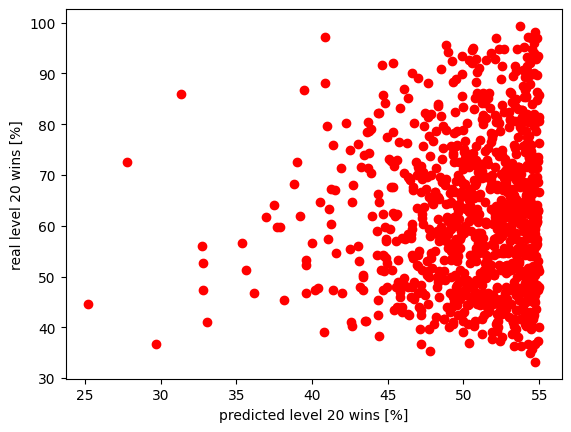

In [20]:
xreal1=np.load('mcx_v1_all.npy')
xreal2=np.load('mcx_v2_all.npy')
xreal3=np.load('mcx_v3_all.npy')
xpred1=np.load('pred_xgb_sel1.npy')
plt.plot(xpred1[0:20],np.mean(xreal1[40,:,:],1),'o',color='red') 
plt.plot(xpred1[20:340],np.mean(xreal2[40,:,:],1),'o',color='red') 
plt.plot(xpred1[340:950],np.mean(xreal3[40,:,:],1),'o',color='red') 
#plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("predicted level 20 wins [%]")
plt.ylabel("real level 20 wins [%]")
print(np.mean(np.mean(xreal2[40,:,:],1)))
print(np.meean(np.mean(xreal3[40,:,:],1)))
print(np.mean(xreal3[40,:,:],0))
#later compare with best input model is no 3 and see whether it improves, likely  not 

Better than randomly created model, but many are much worse than the input minimum limit of 55 %. Try more tonight, but likely should do gradient. 

In [13]:
print(9*3600/(16865/320)+340)

954.7643047731989
